In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
from sklearn.utils import shuffle
warnings.filterwarnings("ignore")

***Notes***

1. ```dt_complementary``` merges the original calendar and price data to know the ```date``` when the ```product_id``` of the ```store_id``` was saled at. Additionaly to know if they were particular events like ```SNAP``` purchases or major events, check the documentation.

2. ```dt_sales_s```. In case you don't have enough RAM take initial n rows of the original dataframe and shuffle the data, because it is ordered.

3. ```dt_sales_melt```. Melt the dataframe so that each sale by product can be seen as row.

4. ```dt_work```. Merges ```dt_sales_melt``` with ```dt_complementary``` to know for each day of sale the price and relevant events associated to that day.

#### Load and transform data

In [2]:
# Load data
files = ['data/calendar.csv', 'data/sales_train_validation.csv', 'data/sell_prices.csv']
data = [pd.read_csv(f) for f in files]
dt_calendar, dt_sales, dt_prices = data

# Merge calendar and prices
dt_complementary = dt_prices.merge(dt_calendar, how='left', on='wm_yr_wk')

# Shuffle data (it is originally ordered) and take n rows (if you don't have enough RAM)
dt_sales_s = shuffle(dt_sales, n_samples = 2500)

In [3]:
# Melt sales data
indicators = [f'd_{i}' for i in range(1,1914)]

dt_sales_melt = pd.melt(dt_sales_s, 
                        id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                        value_vars = indicators, var_name = 'day_key', value_name = 'sales_day')

dt_sales_melt['day'] = dt_sales_melt['day_key'].apply(lambda x: x[2:]).astype(int)

In [4]:
# Data to work with
columns = ['store_id','item_id','sell_price','date','year','d','event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']
dt_work = dt_sales_melt.merge(dt_complementary[columns], how = 'left', left_on=['item_id','store_id','day_key'], right_on=['item_id','store_id','d'])
print(dt_work.shape)

(4782500, 20)


#### Global Granularity

In this section, we visualize the time series of the ```sum``` of the ```sales_day``` and the ```mean``` of ```sell_price``` by different levels of granularity. For example, sales and price by state. Above, the ```particular granularity``` show us a deeper level of granularity by displaying the data for the different levels of granularity in each store, for example, the sales and price by category of each store. 

In [5]:
def timeseries_global(data:'pd.DataFrame',level:str):
    
    # Group data by level 
    dt_level = data.groupby([level, 'day']).agg({'sales_day':'sum','sell_price':'mean'}) \
                                                         .reset_index() \
                                                         .sort_values(by=[level,'day'])
    
    # Visualize by components of level 
    levels = dt_level[level].unique()

    for l in levels: 
        df = dt_level[(dt_level[level] == l)]
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16,8))
        plt.style.use('ggplot')
        ax1.plot(df['sales_day'], color = 'blue')
        ax1.set_xticklabels(labels = df.day.values, rotation=70)
        ax1.grid(False)
        ax1.set_title(f"Time series of sales for {l}")
        ax2.plot(df['sell_price'], color = 'red')
        ax2.set_xticklabels(labels = df.day.values, rotation=70)
        ax2.grid(False)
        ax2.set_title(f"Time series of price for {l}")

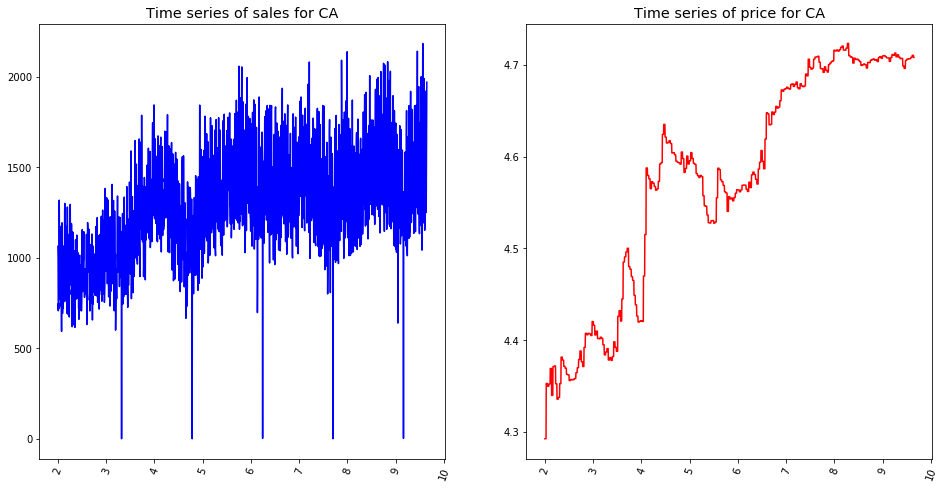

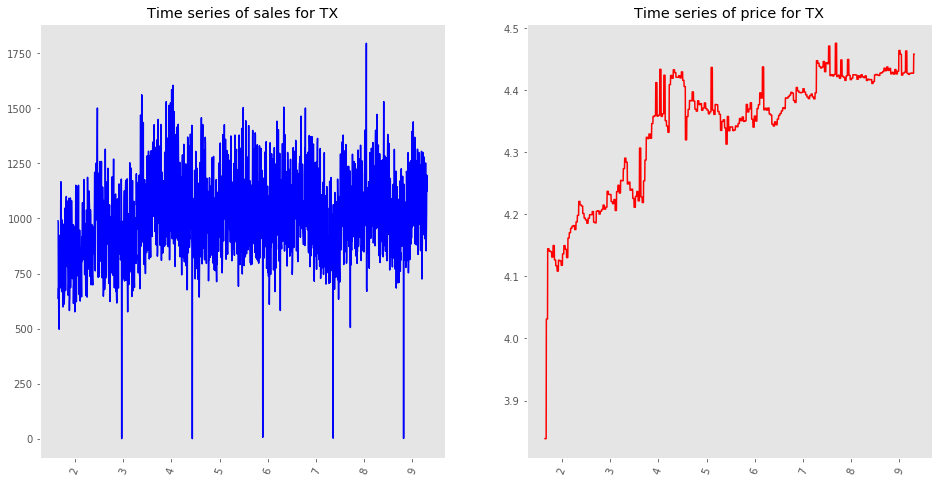

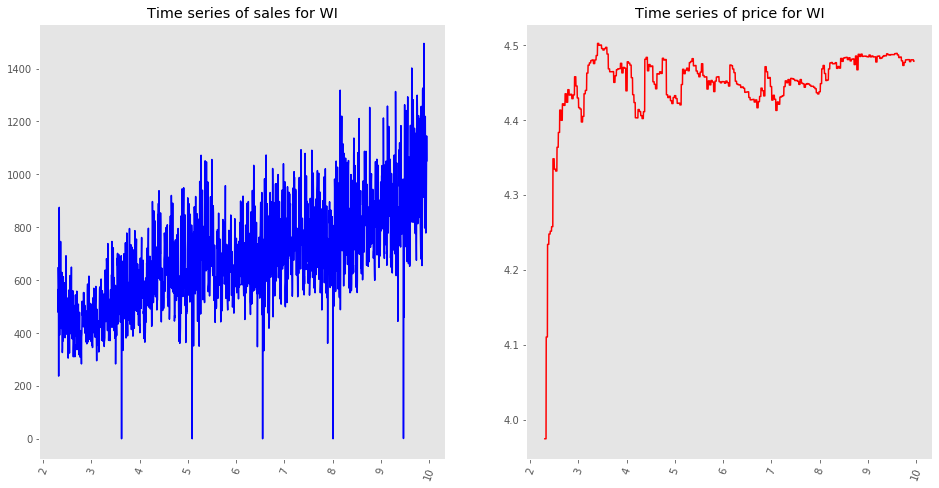

In [6]:
# State level
timeseries_global(dt_work,'state_id')

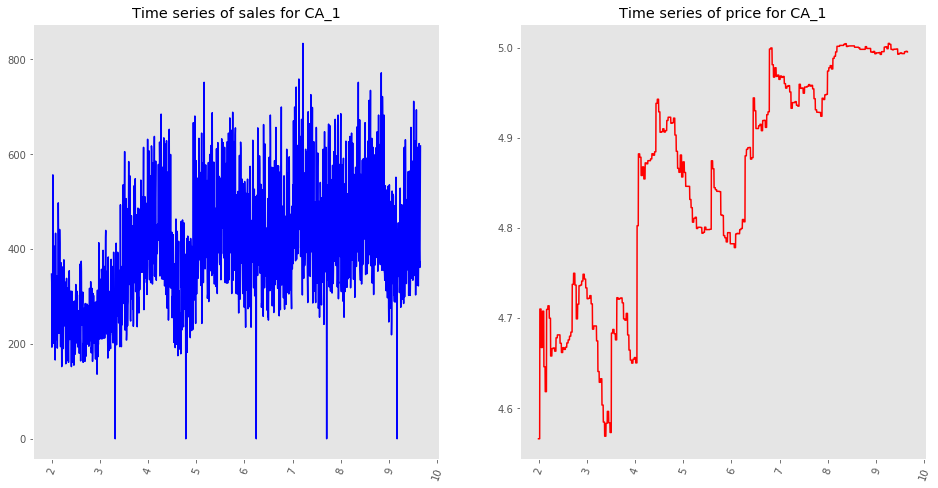

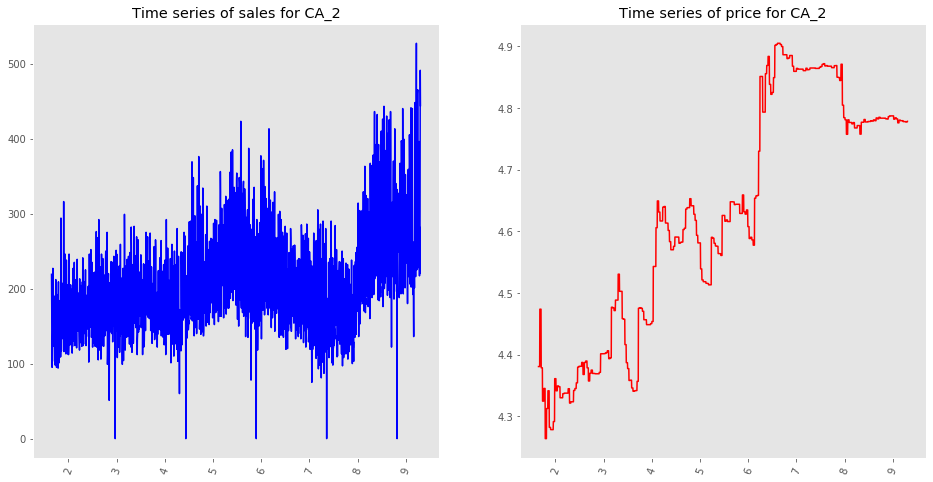

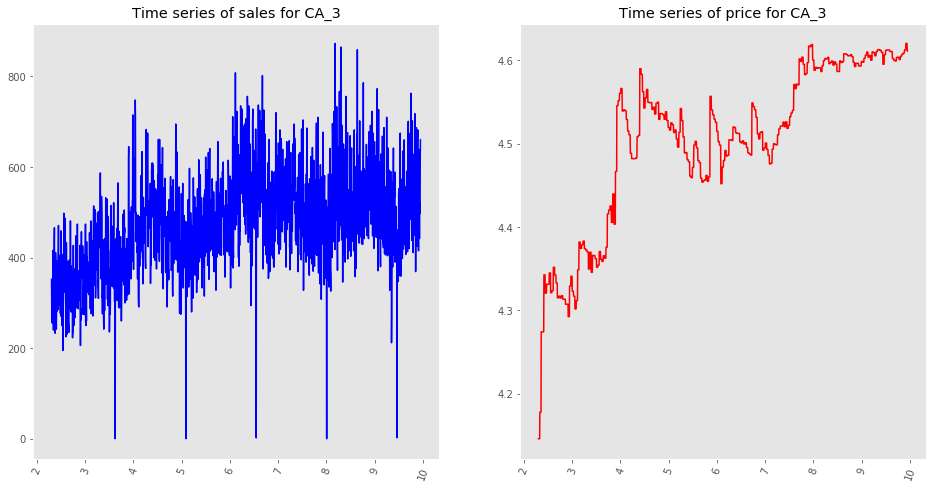

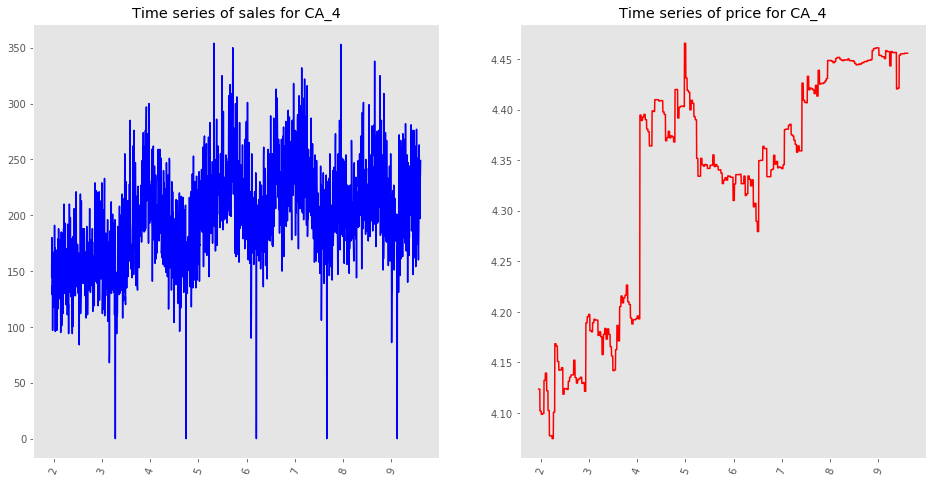

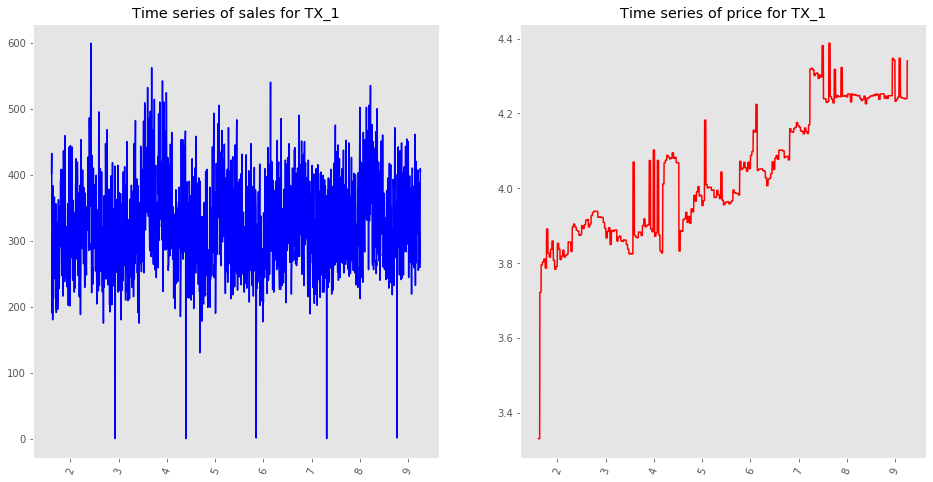

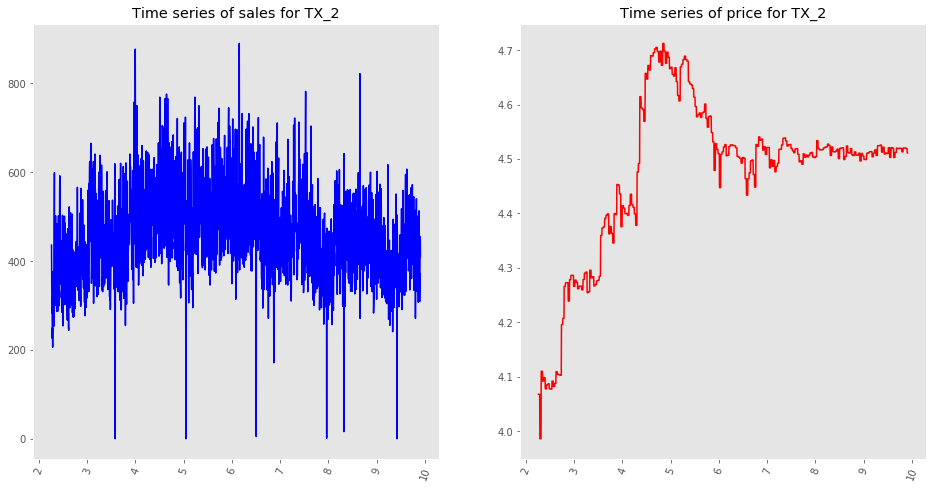

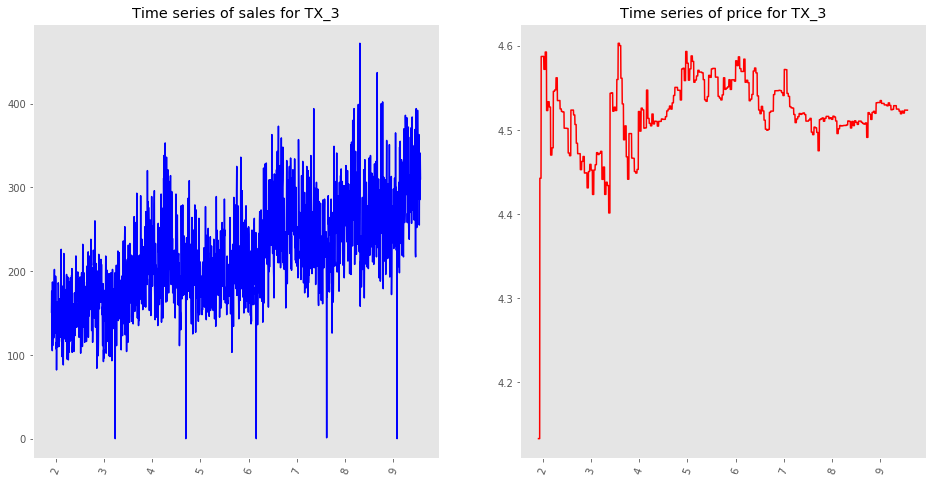

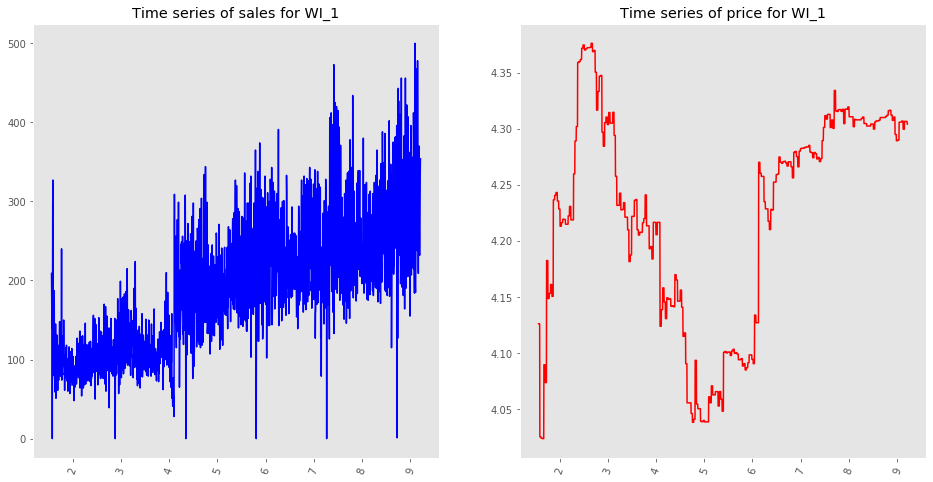

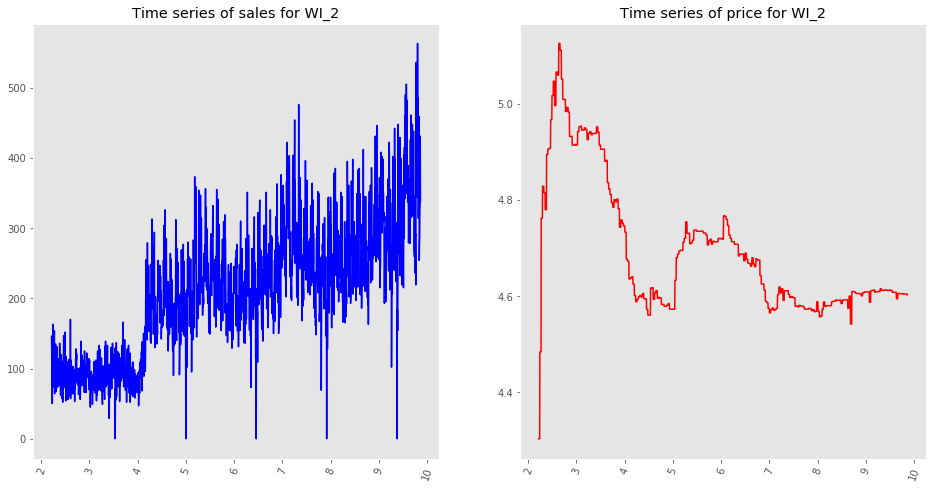

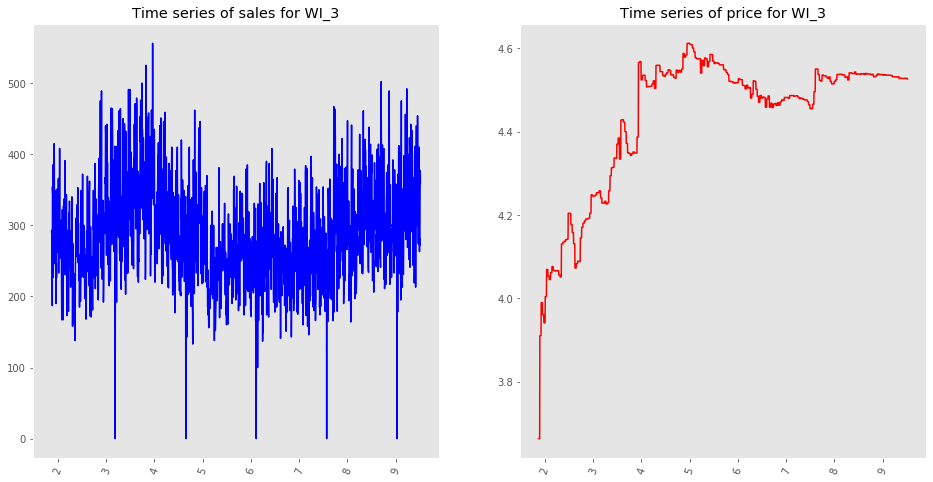

In [7]:
# Store level
timeseries_global(dt_work,'store_id')

#### Particular granularity

In [8]:
def timeseries_particular(data:'pd.DataFrame',level_1:str, level_2:str):
    
    # Group data by level 
    dt_level = data.groupby([level_1,level_2, 'day']).agg({'sales_day':'sum','sell_price':'mean'}) \
                                                               .reset_index() \
                                                               .sort_values(by=[level_1,level_2,'day'])
    
    # Visualize by components of level 
    l1, l2 = dt_level[level_1].unique(), dt_level[level_2].unique() 
    iterables = [(a, b) for a in l1 for b in l2]

    for i in iterables: 
        a, b = i
        df = dt_level[(dt_level[level_1] == a) & (dt_level[level_2] == b)]
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16,8))
        plt.style.use('ggplot')
        ax1.plot(df['sales_day'], color = 'blue')
        ax1.set_xticklabels(labels = df.day.values, rotation=70)
        ax1.grid(False)
        ax1.set_title(f"Time series of sales for {a} and {b}")
        ax2.plot(df['sell_price'], color = 'red')
        ax2.set_xticklabels(labels = df.day.values, rotation=70)
        ax2.grid(False)
        ax2.set_title(f"Time series of price for {a} and {b}")

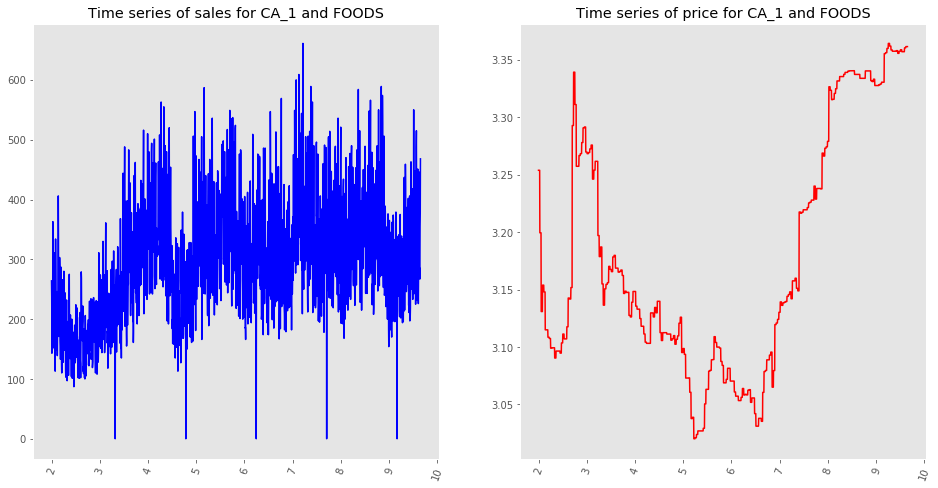

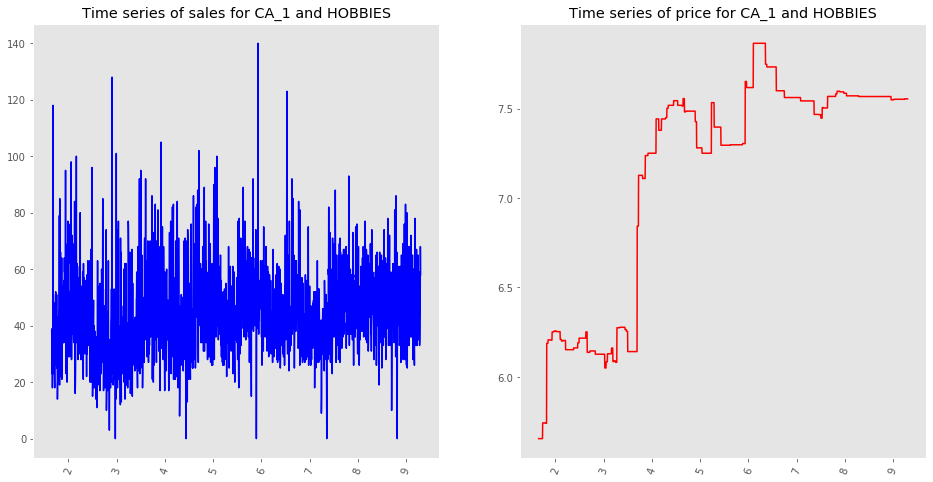

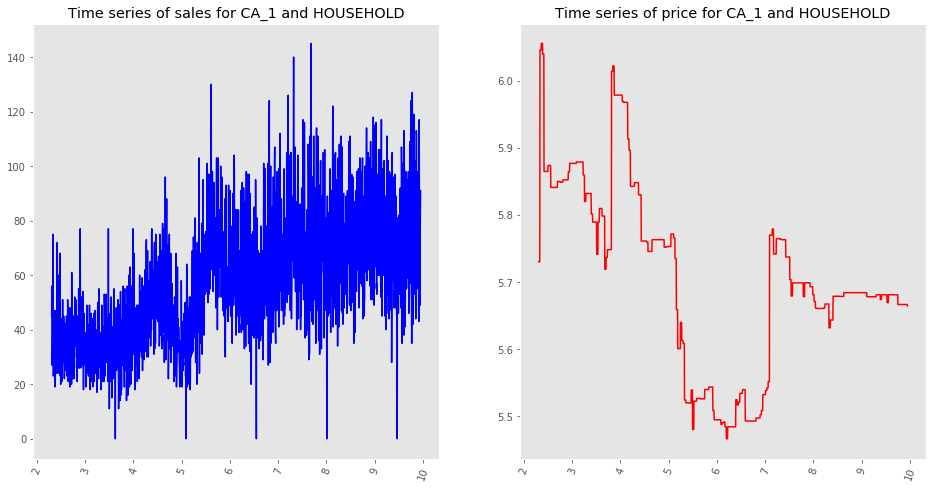

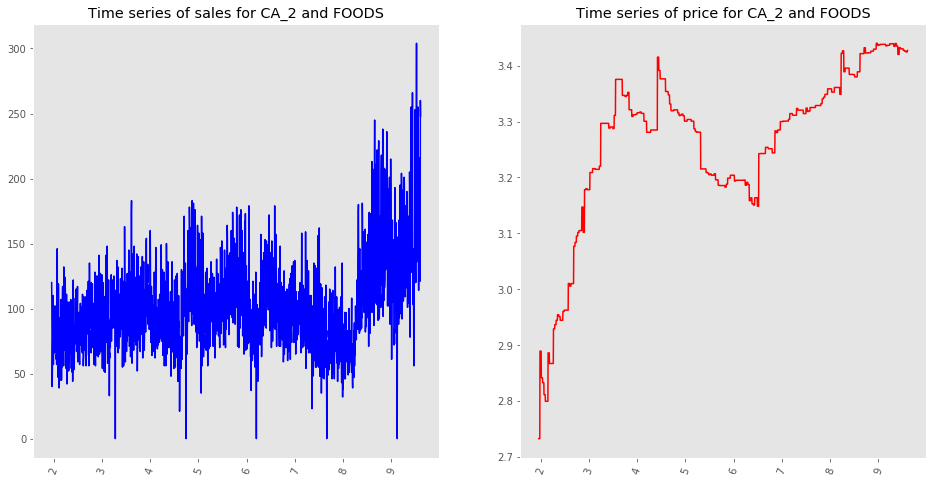

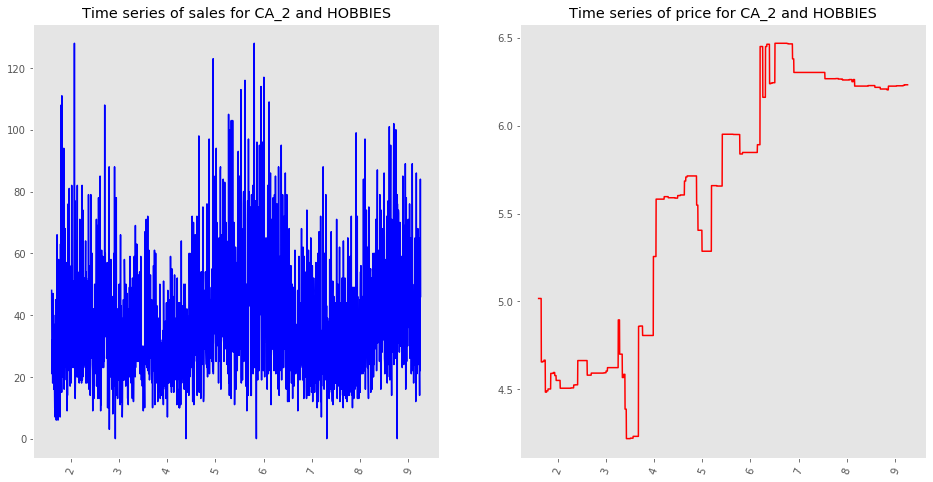

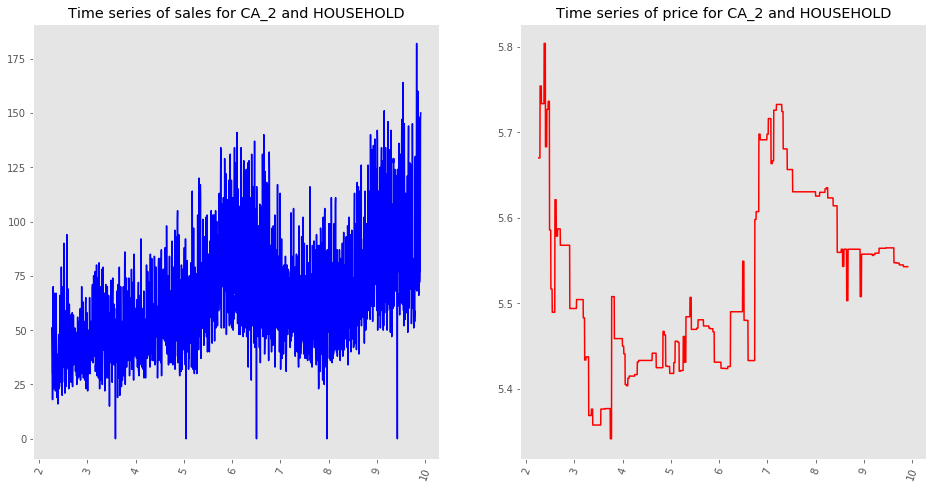

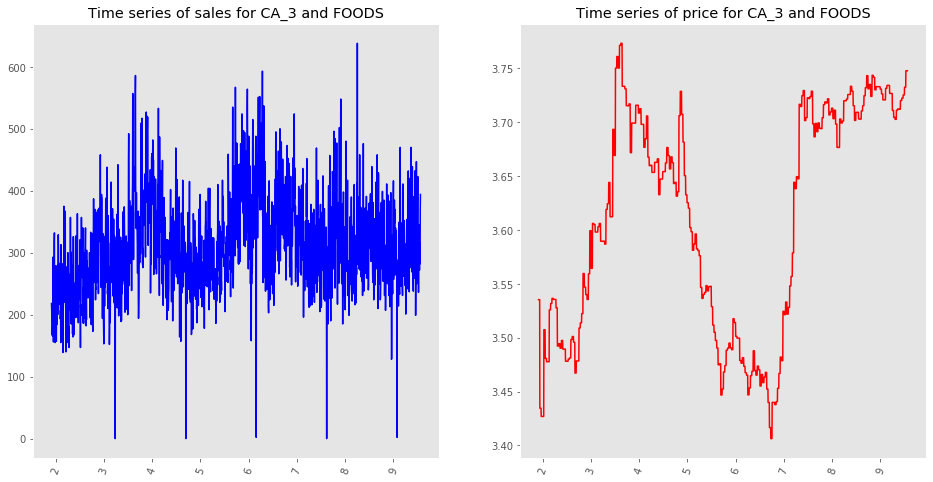

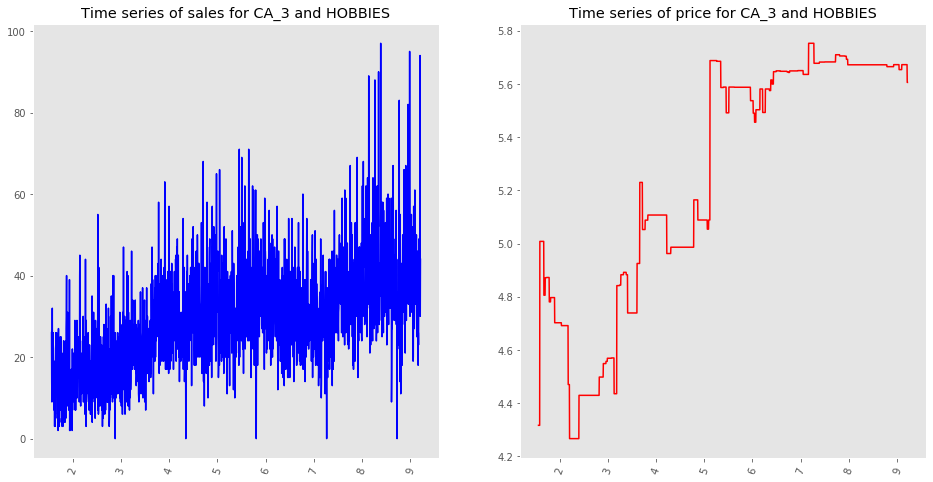

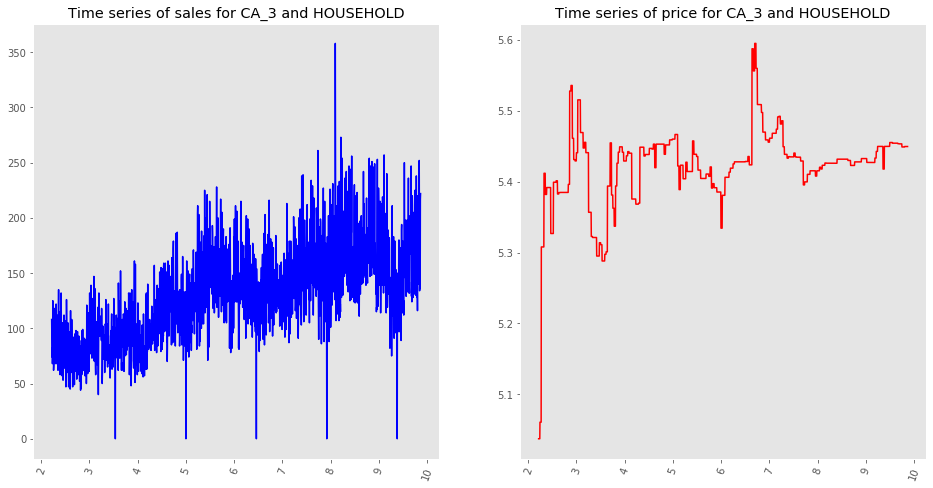

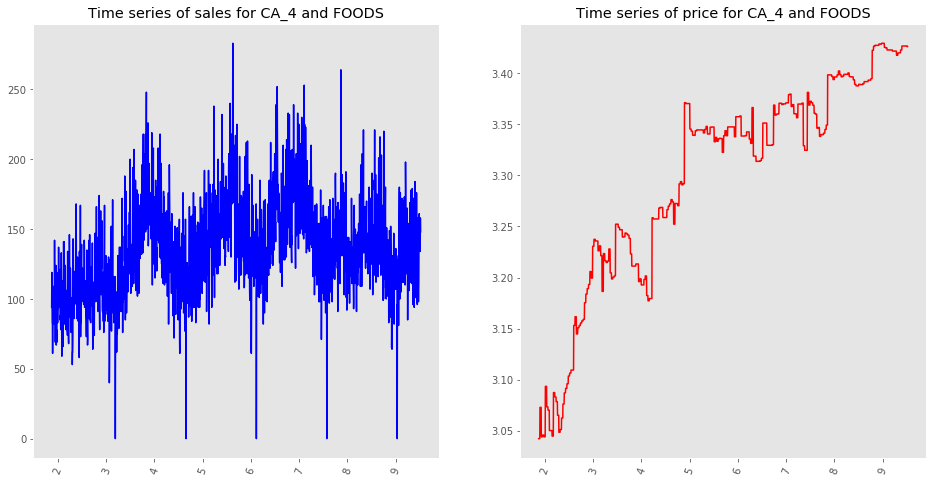

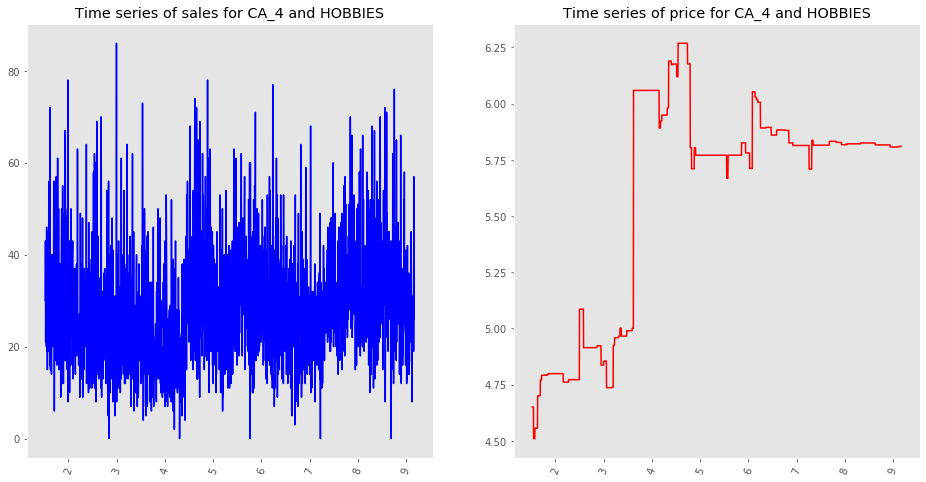

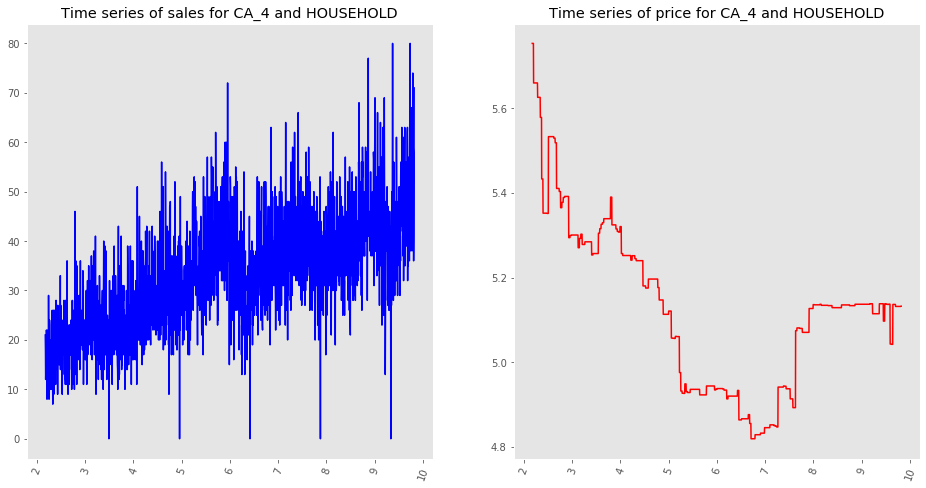

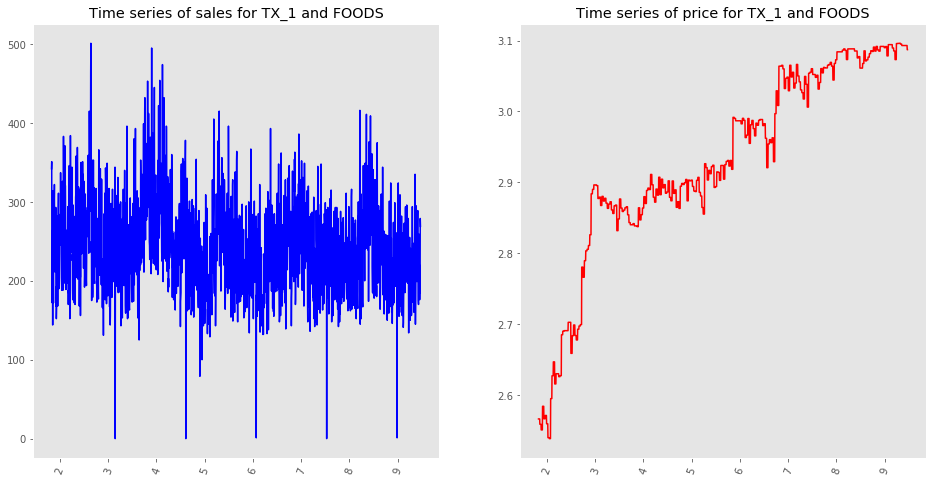

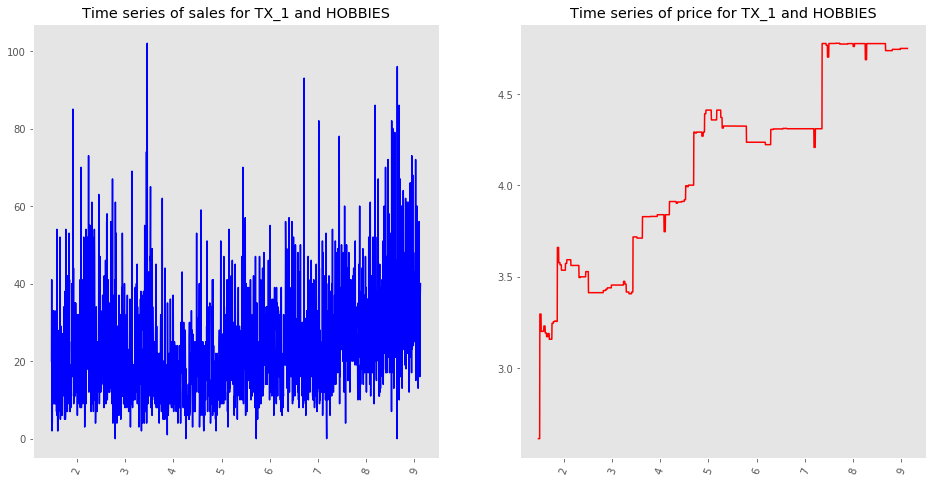

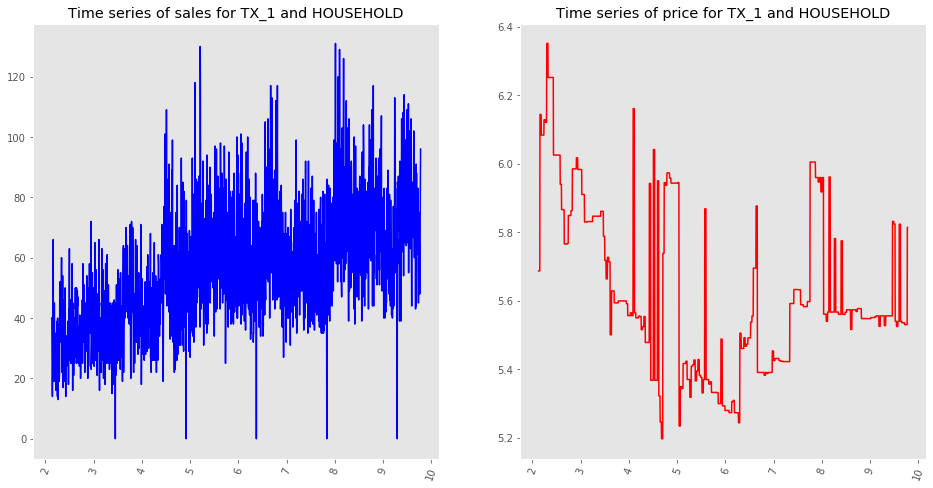

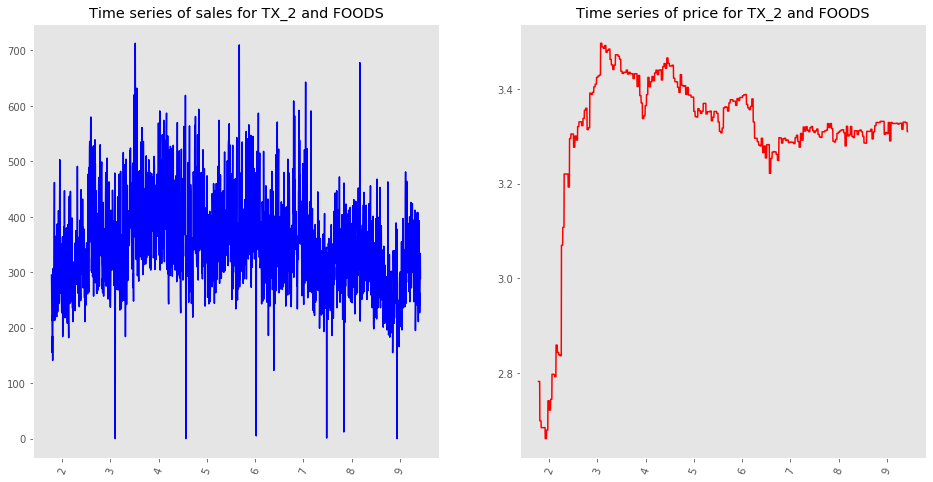

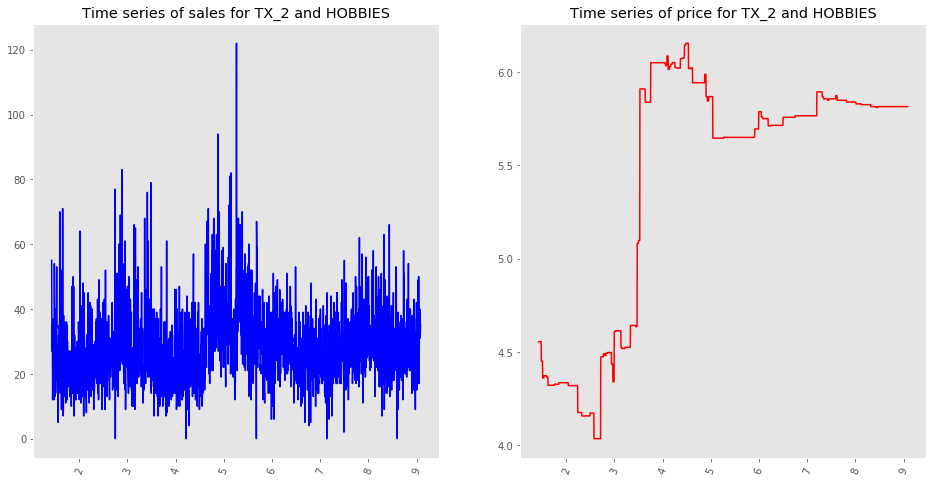

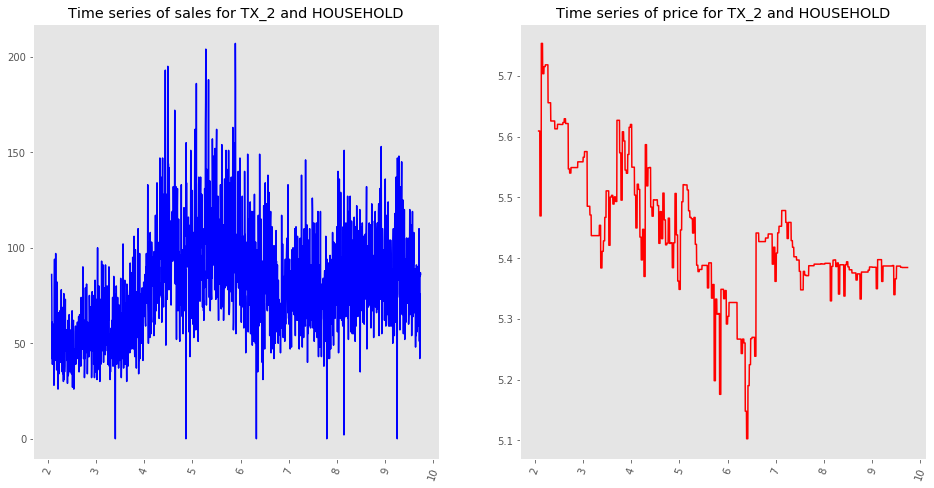

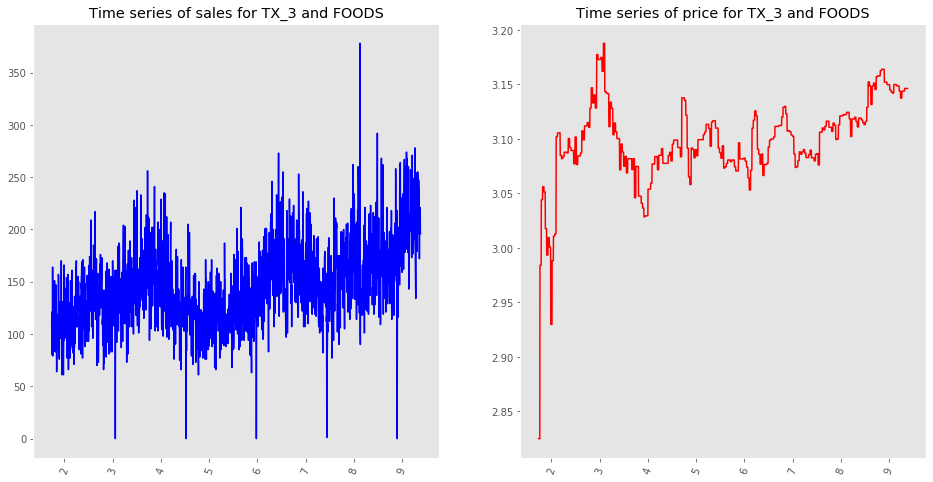

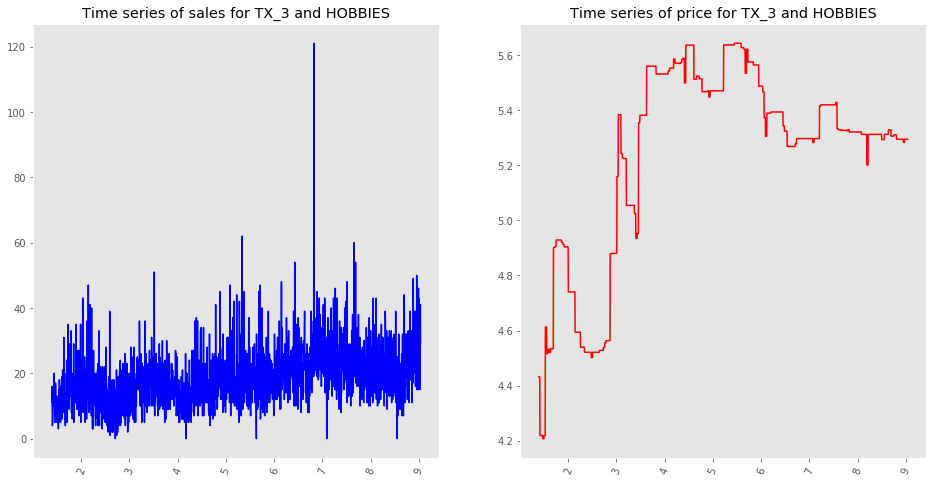

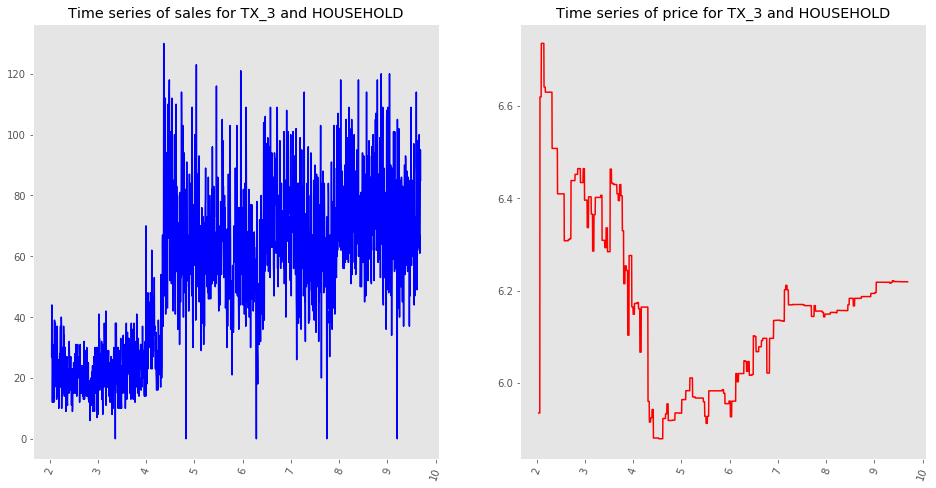

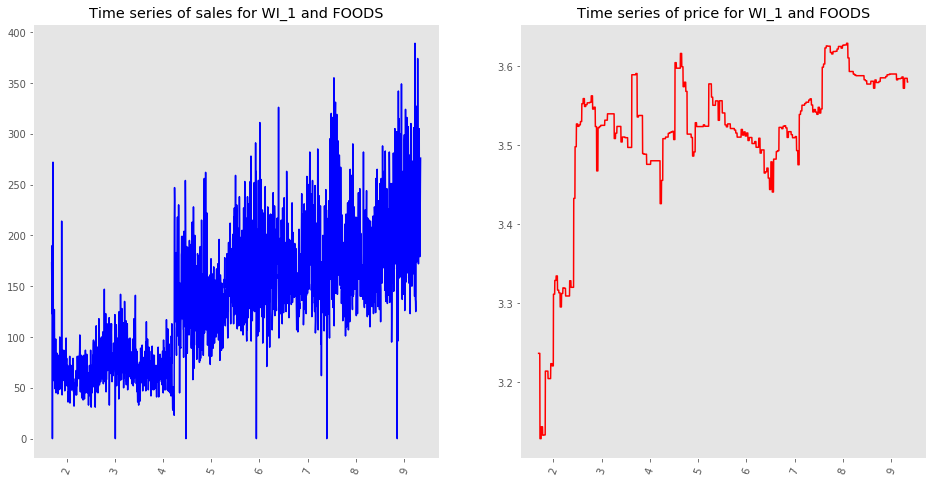

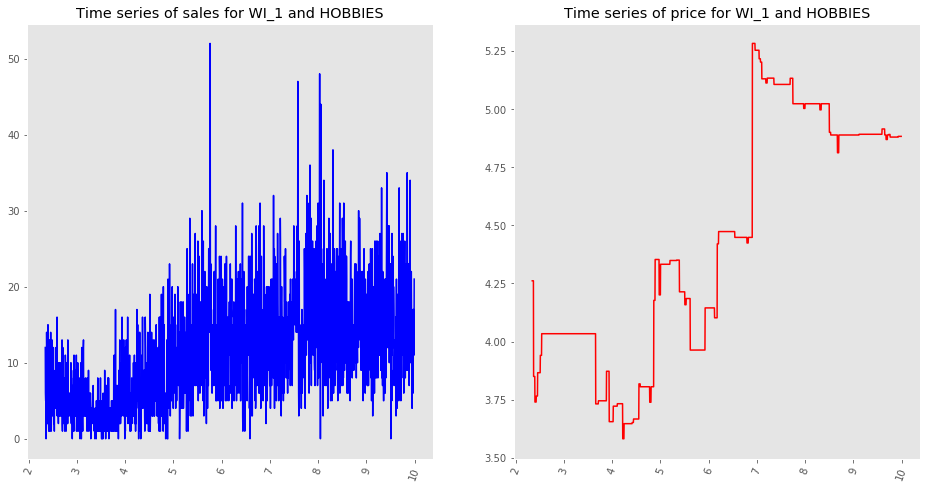

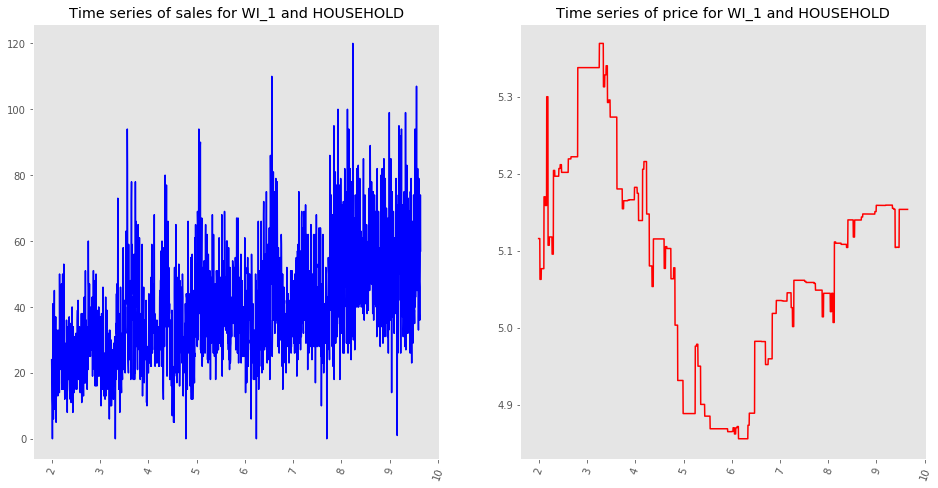

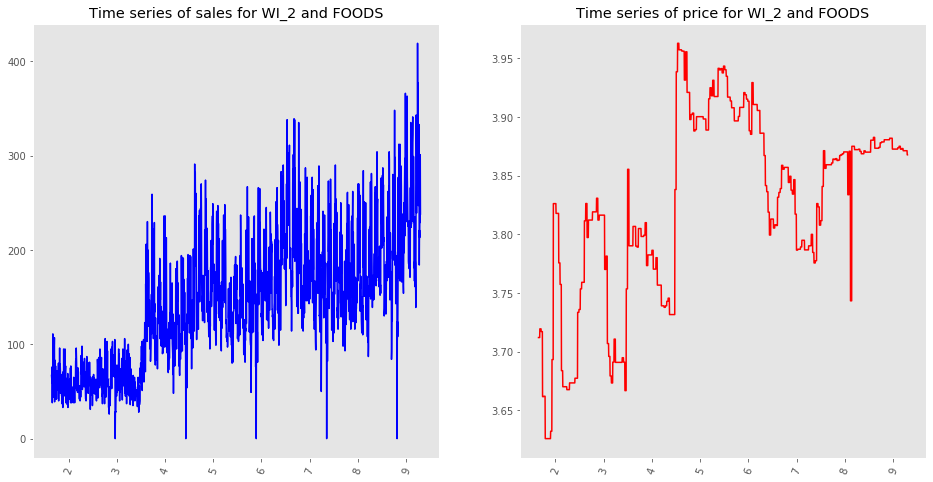

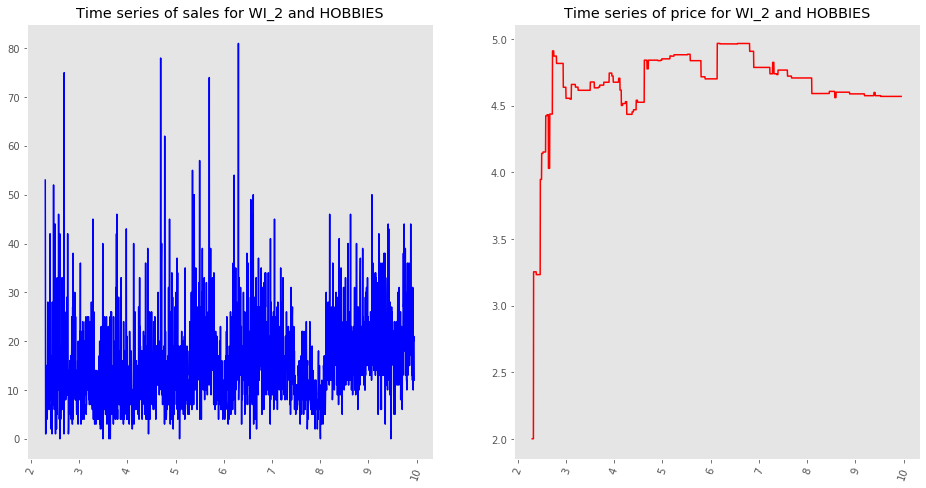

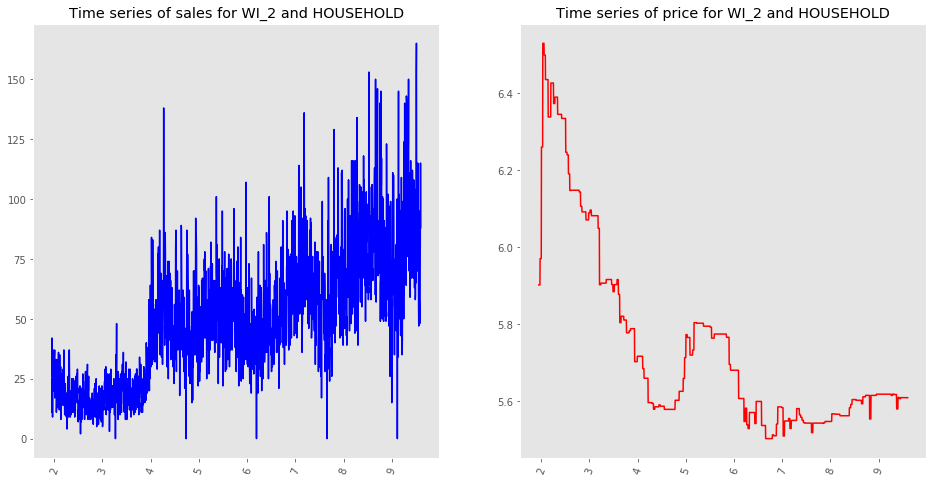

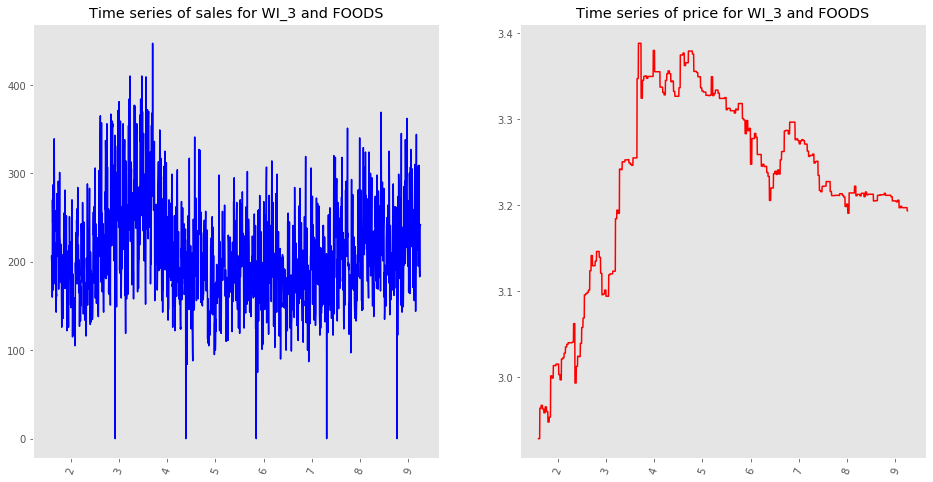

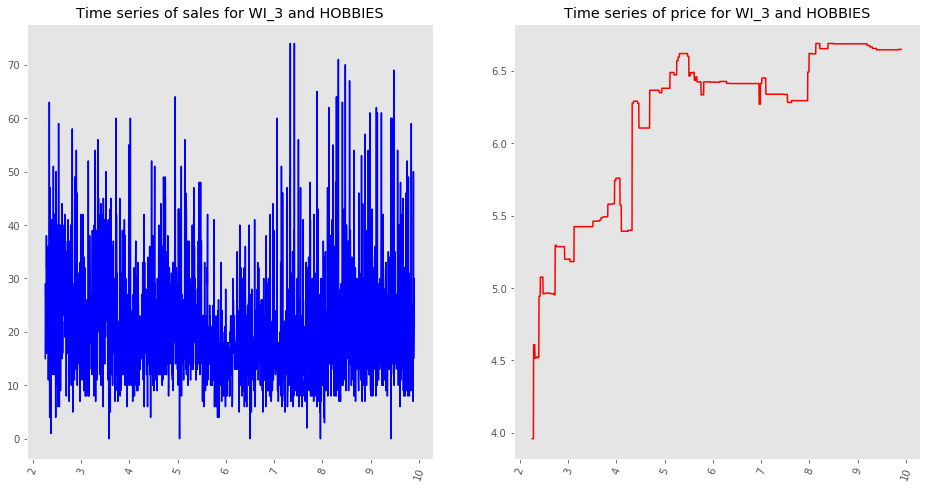

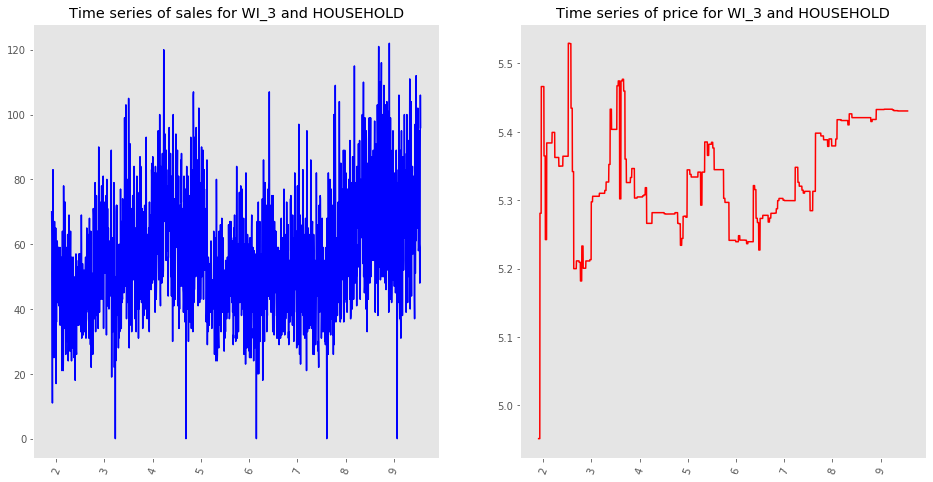

In [9]:
# Level: Categories of each store 
timeseries_particular(dt_work,'store_id', 'cat_id')

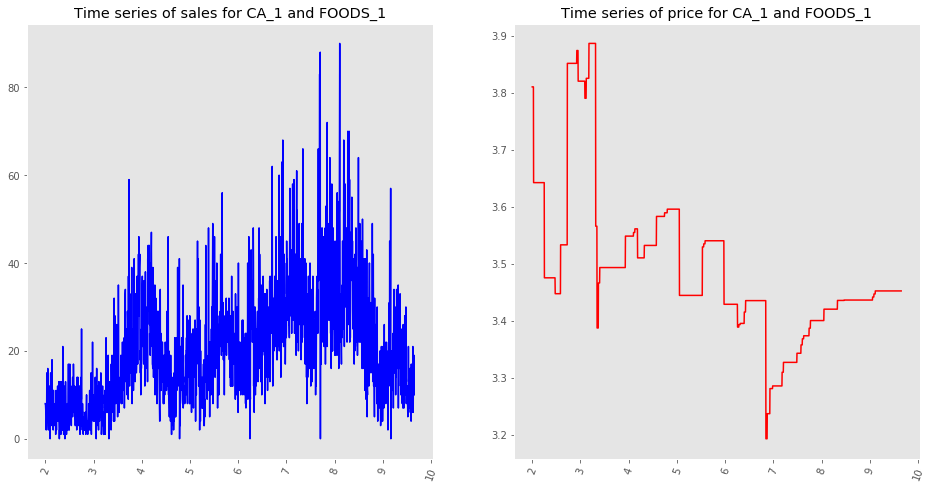

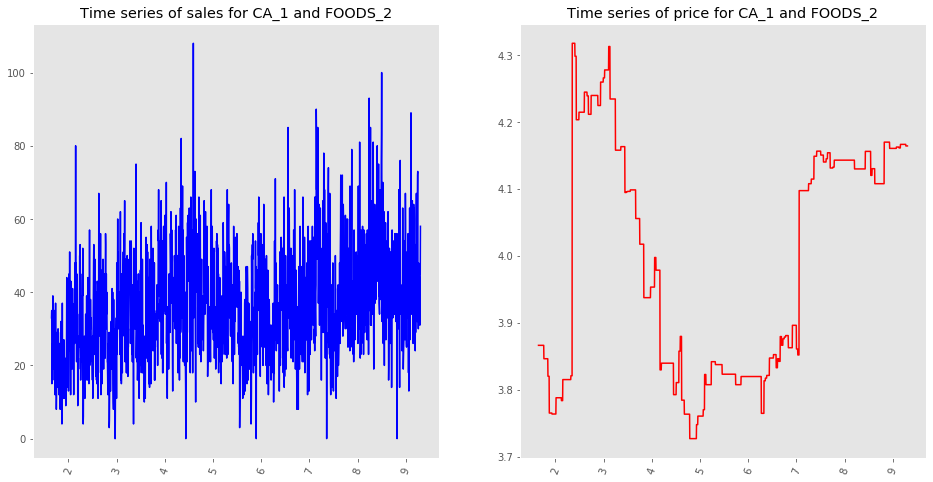

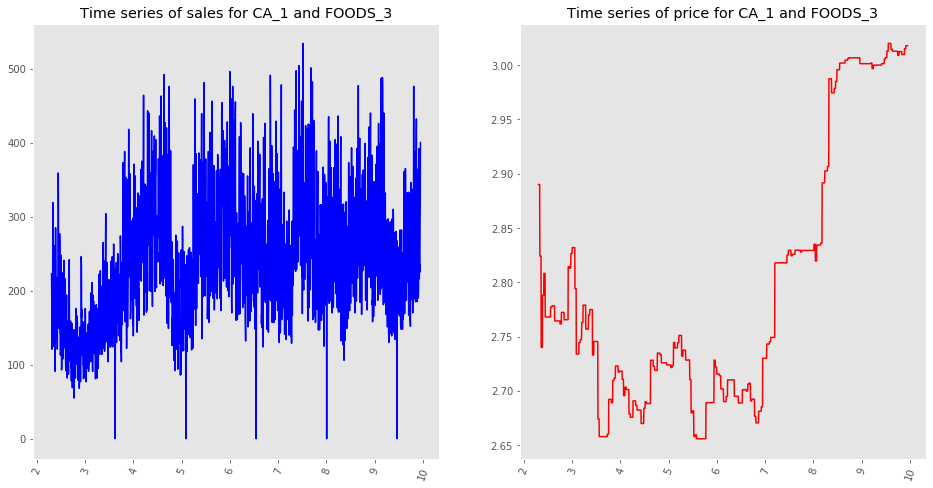

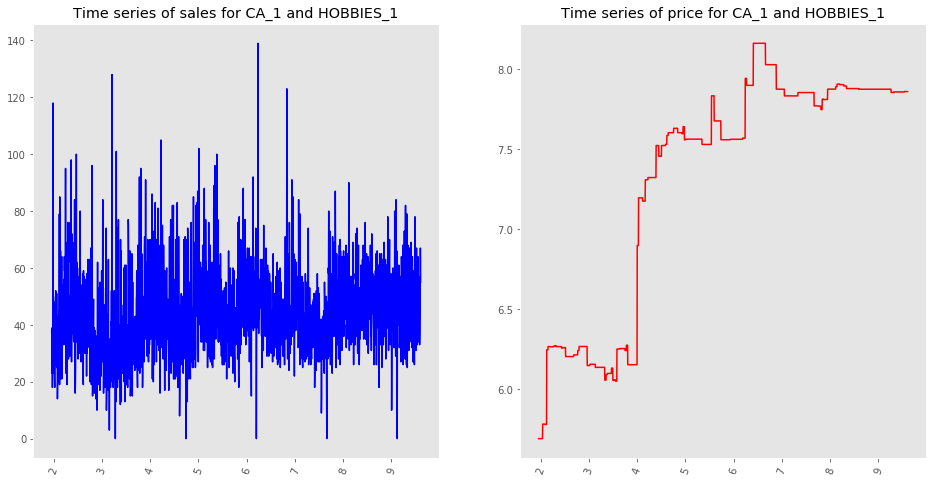

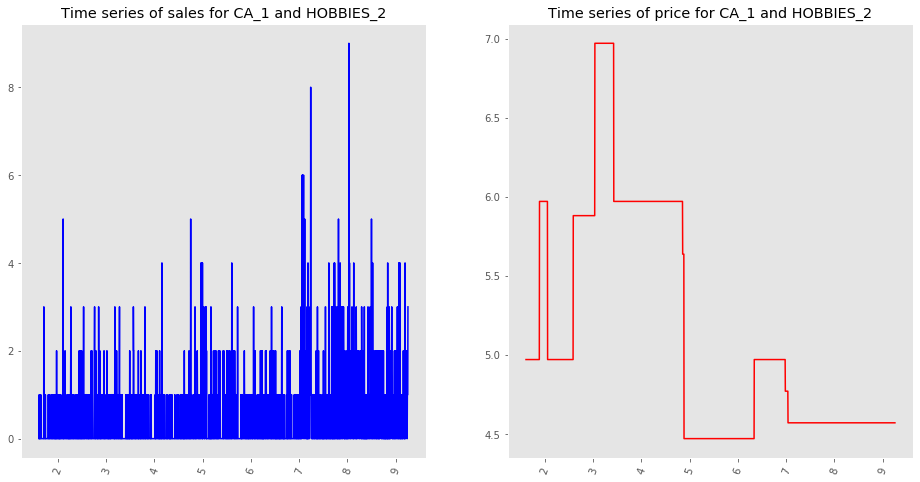

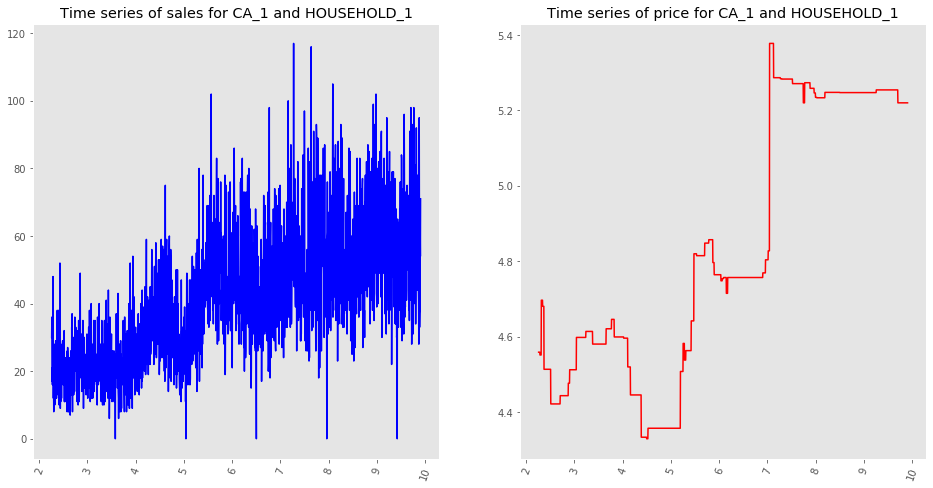

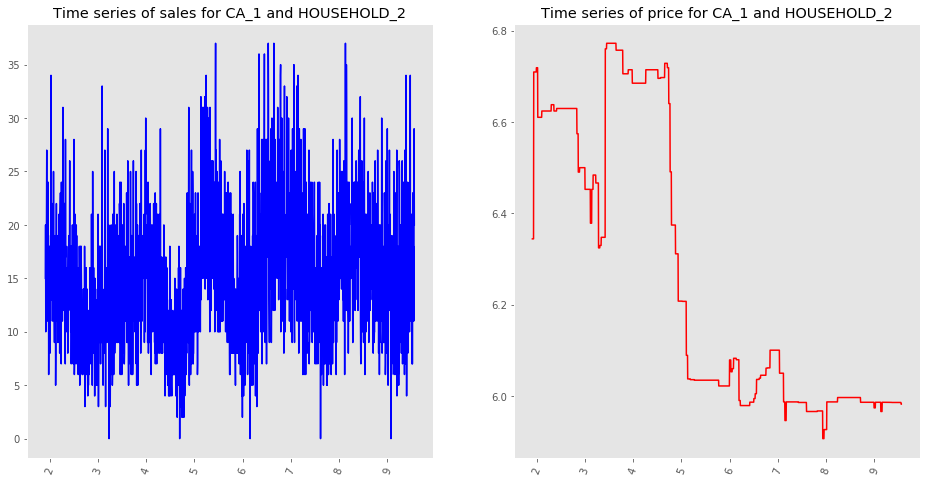

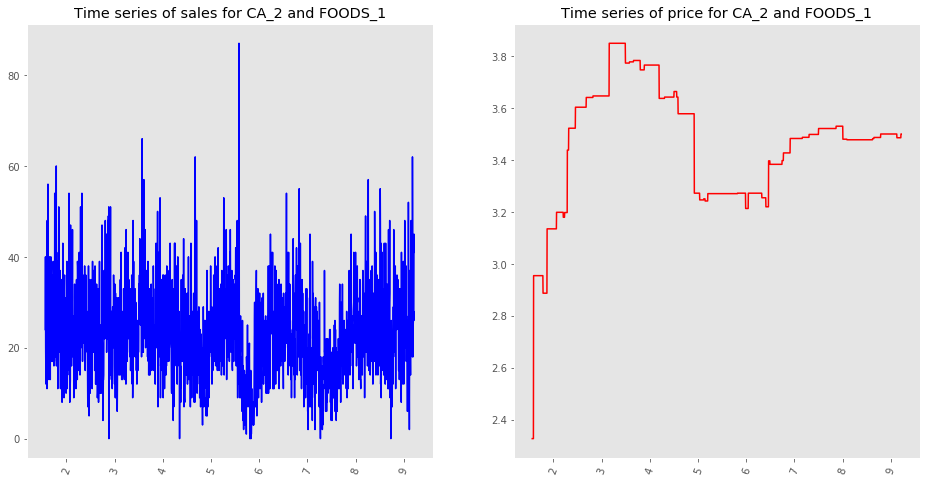

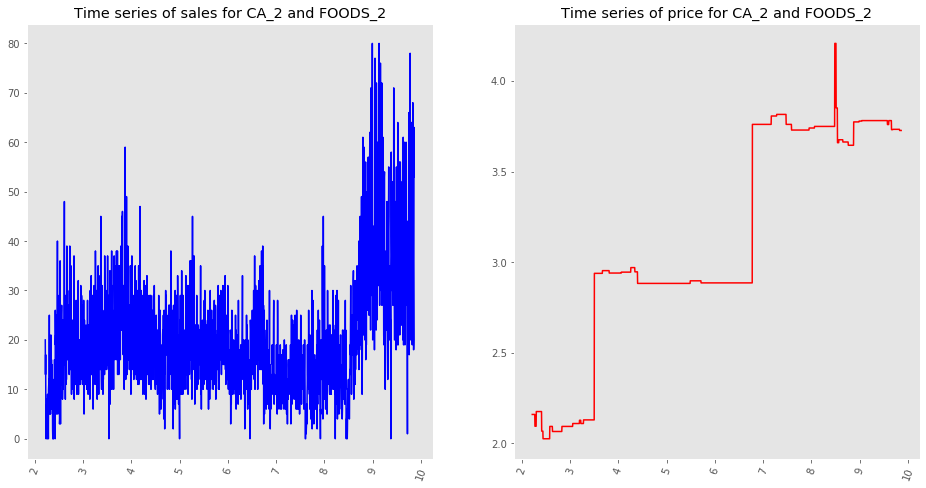

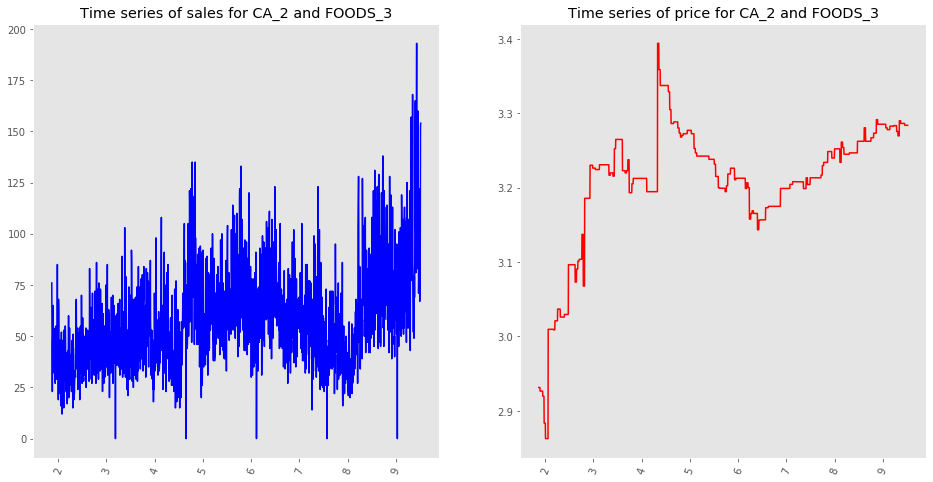

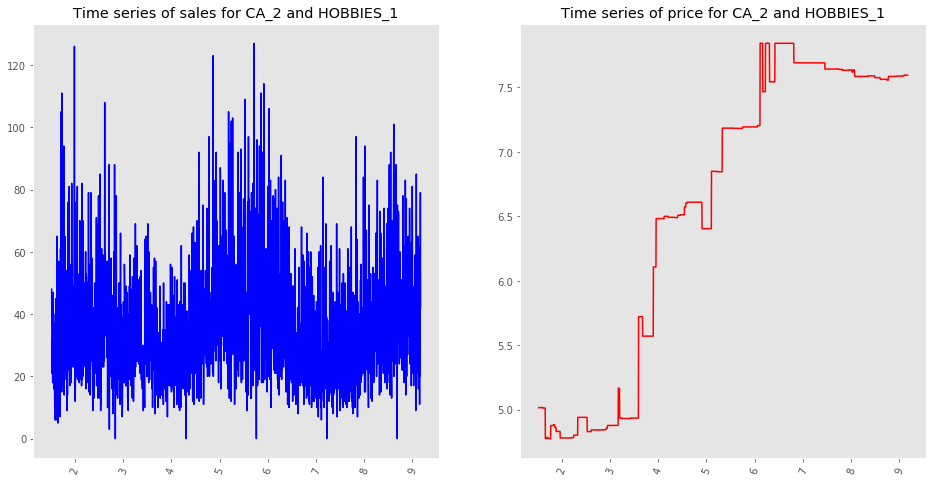

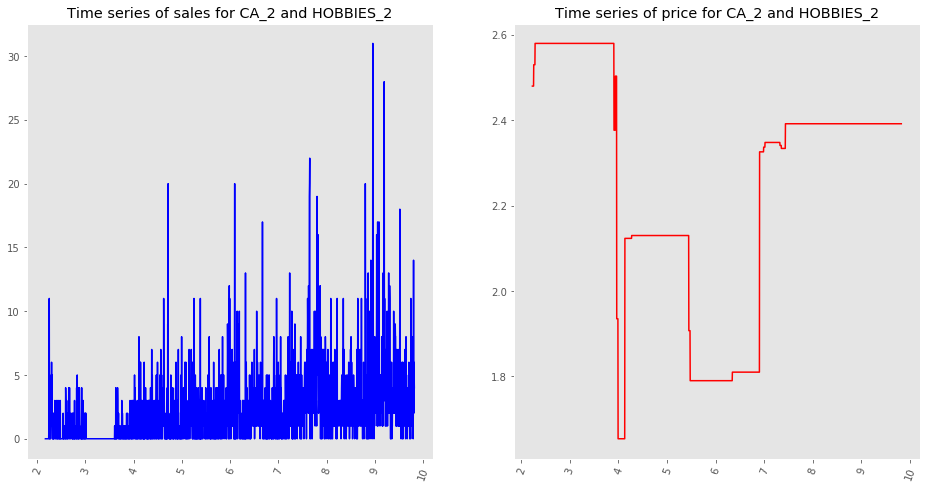

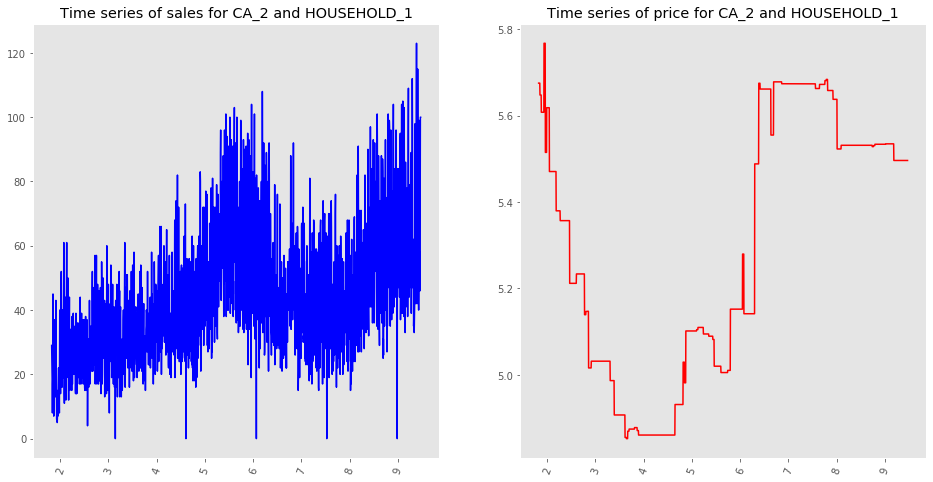

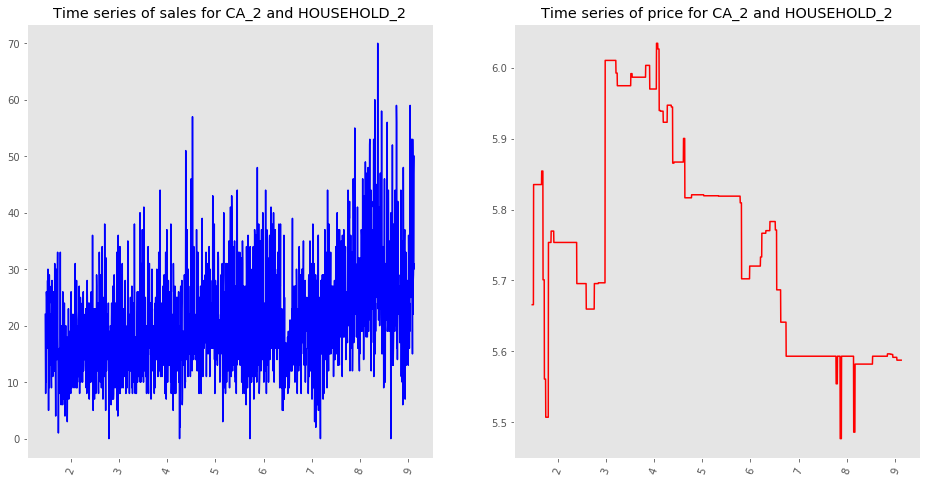

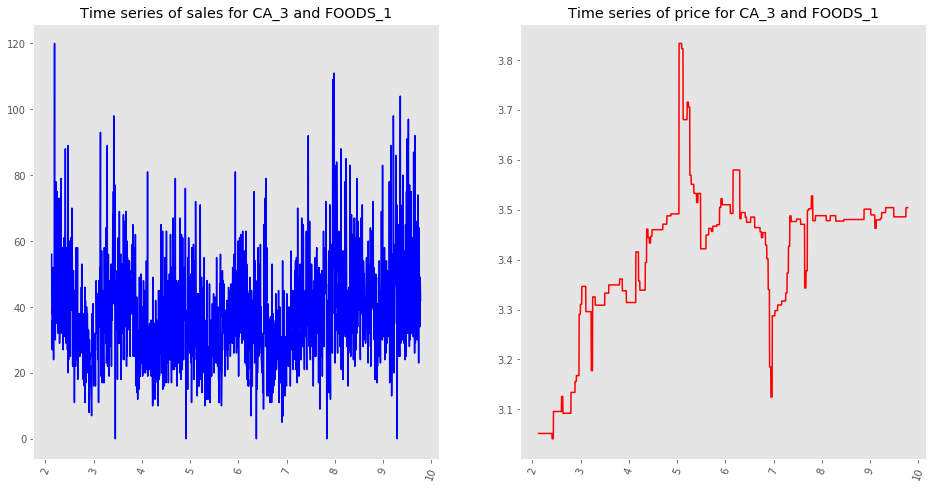

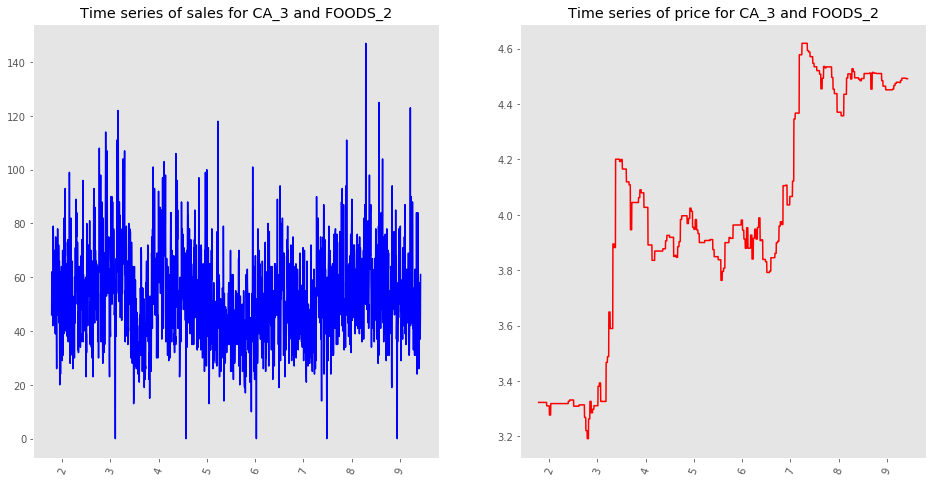

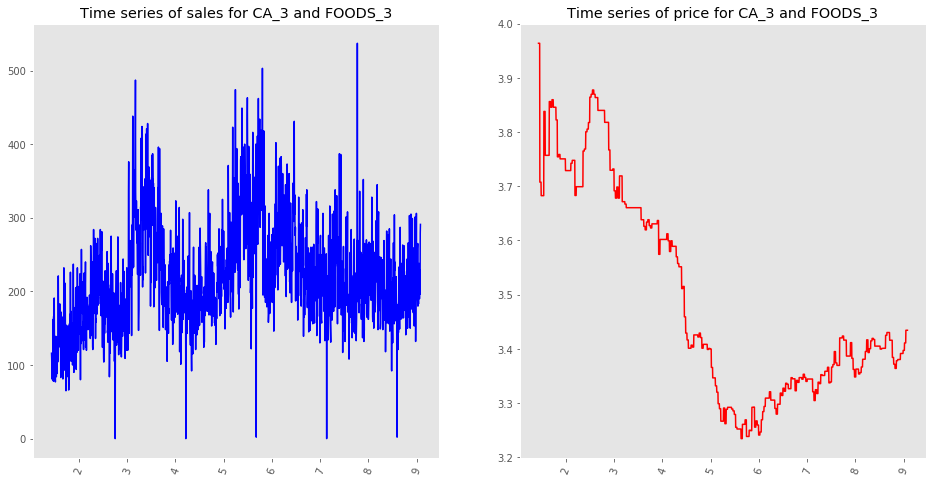

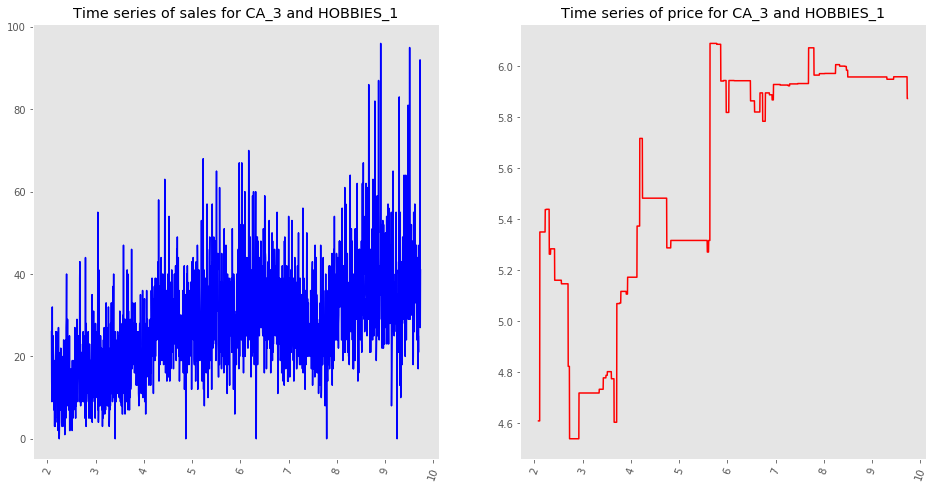

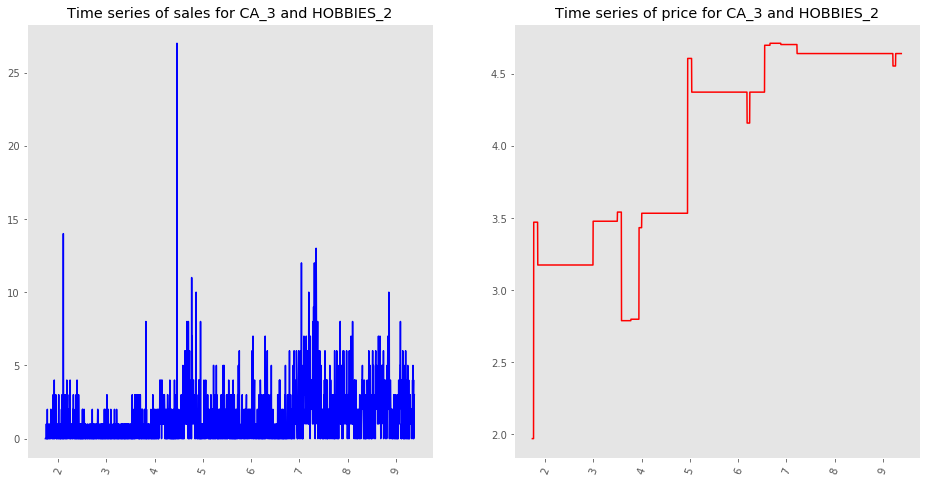

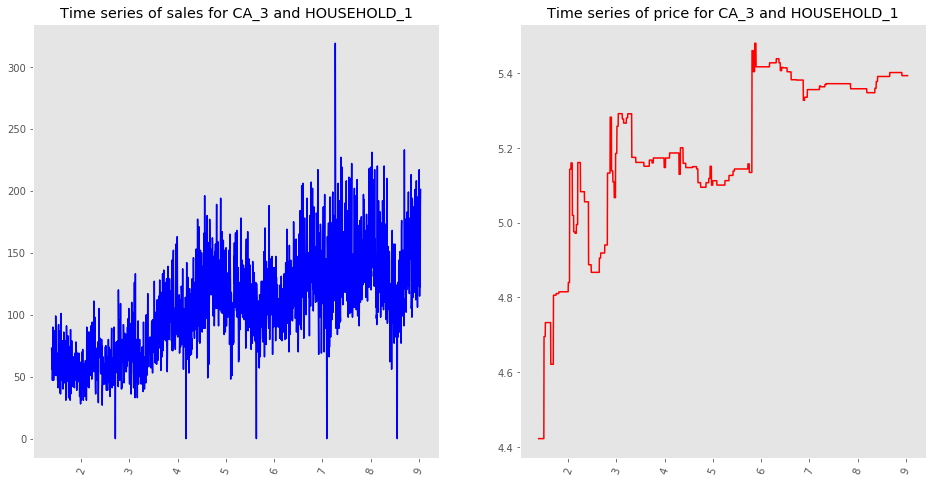

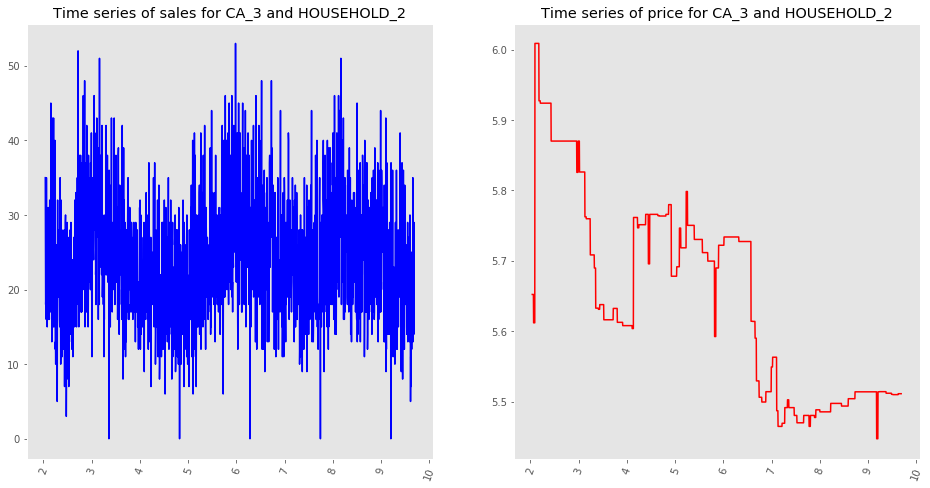

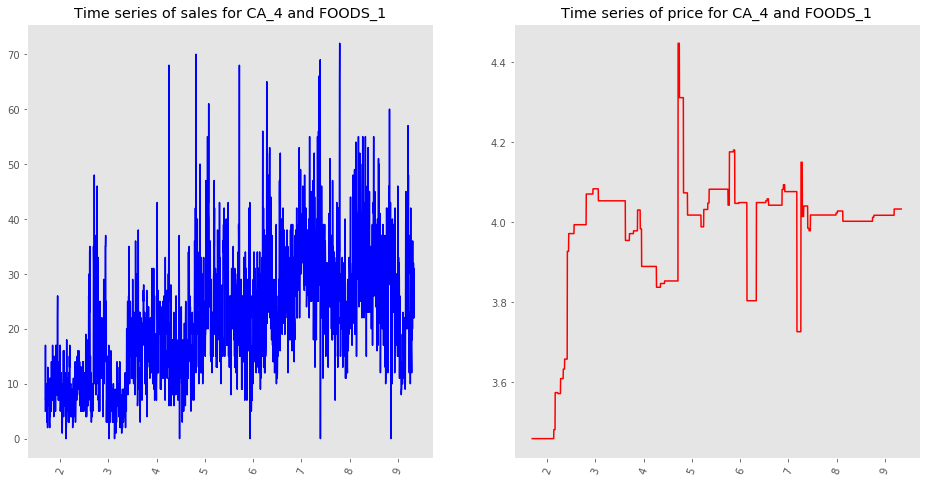

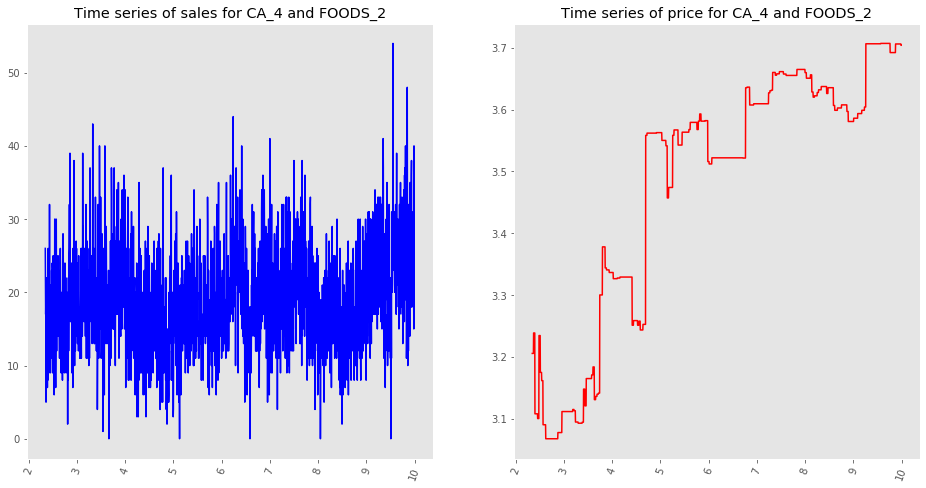

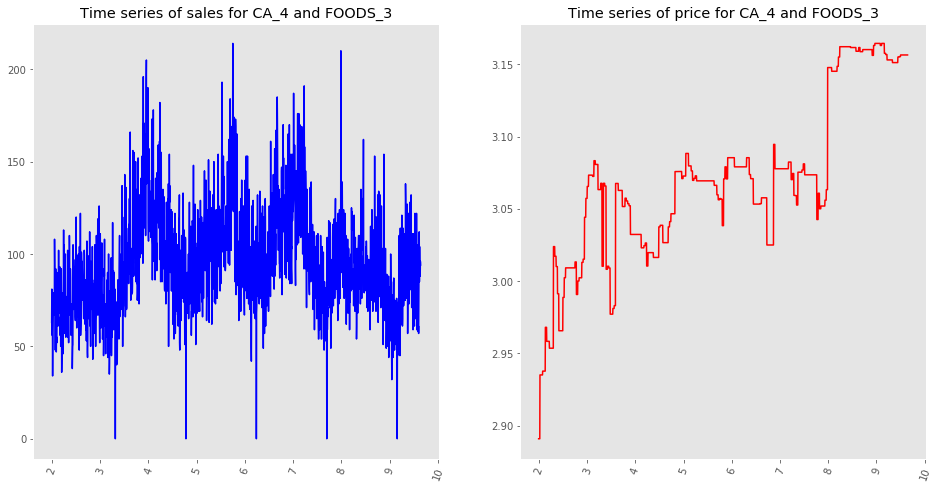

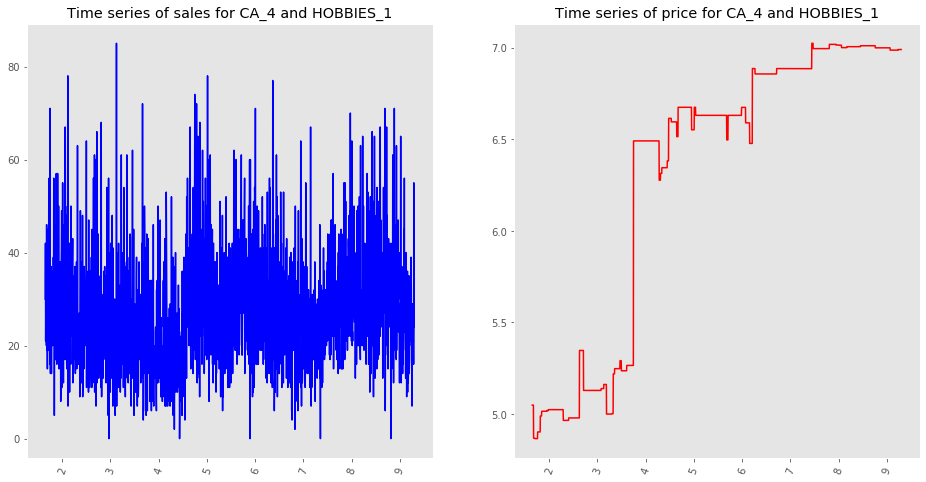

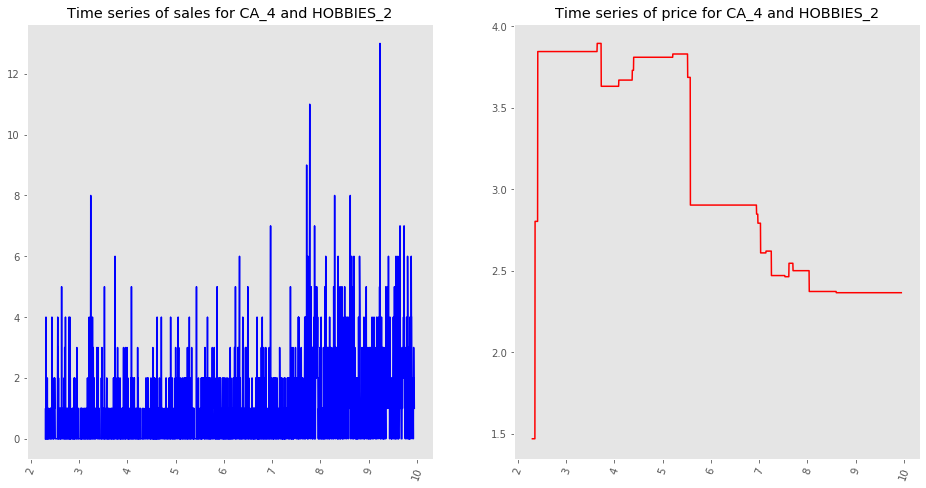

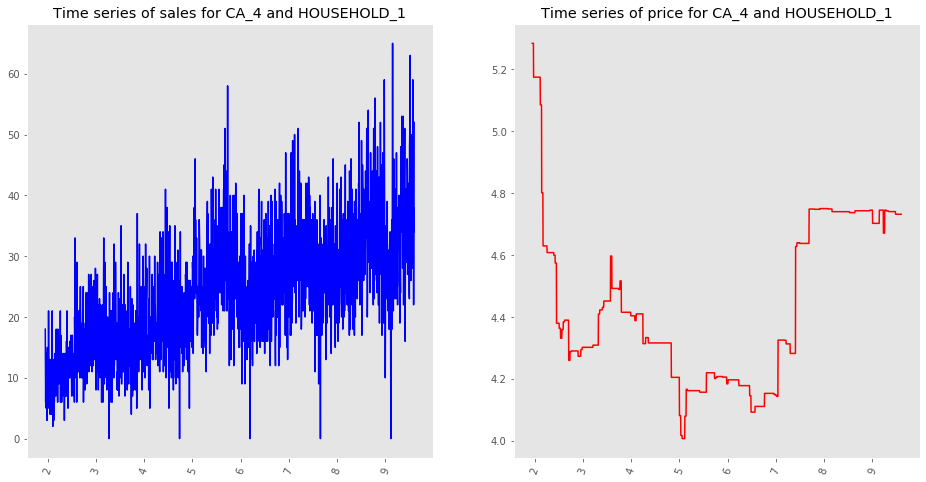

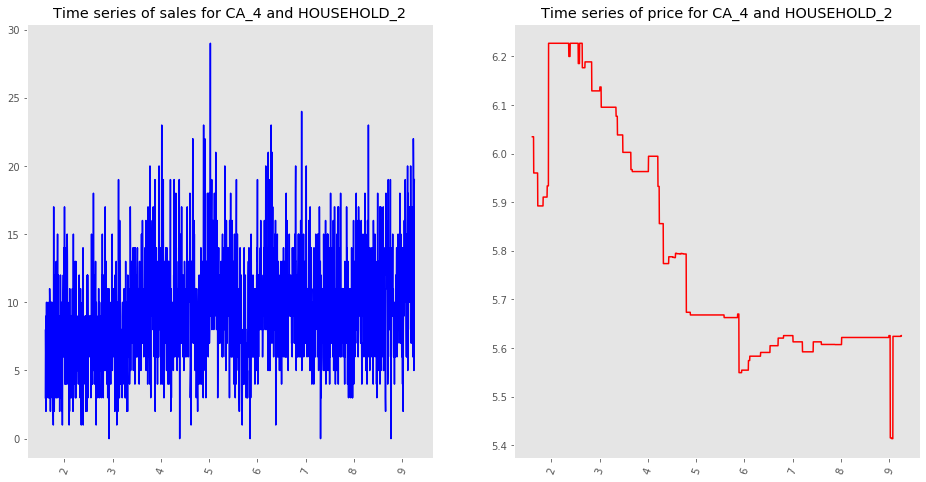

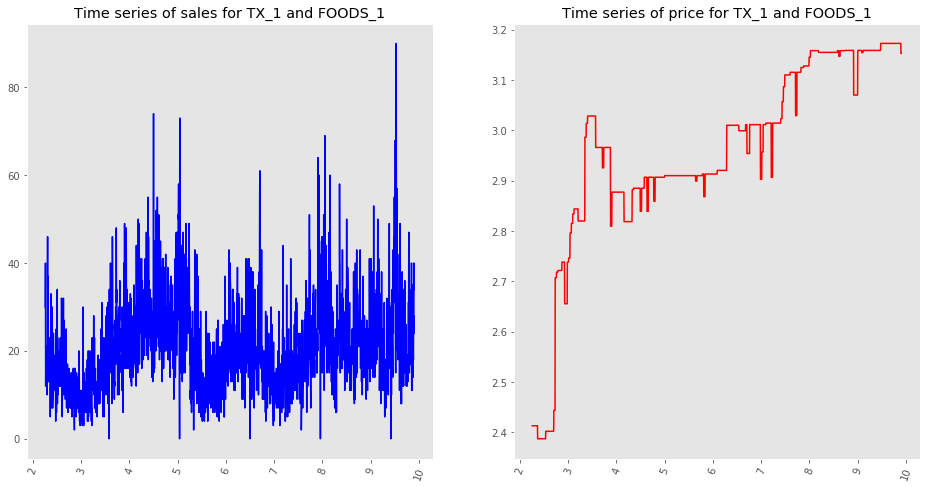

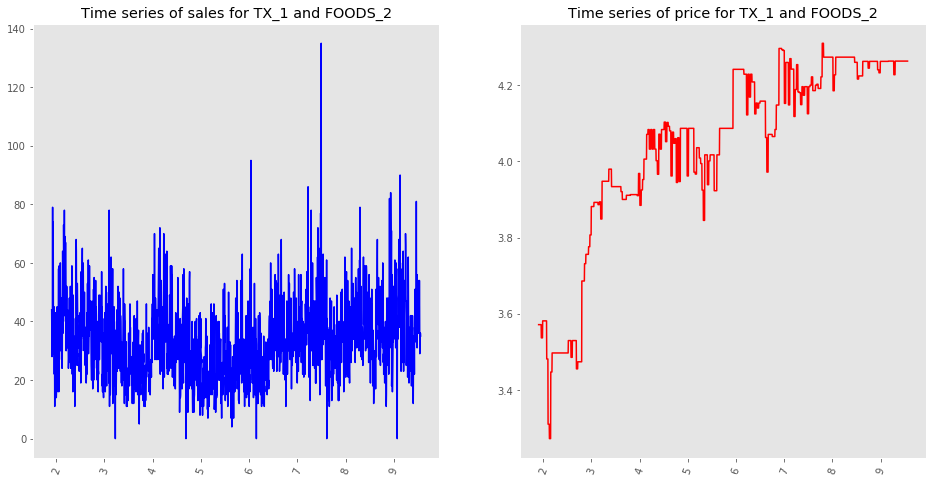

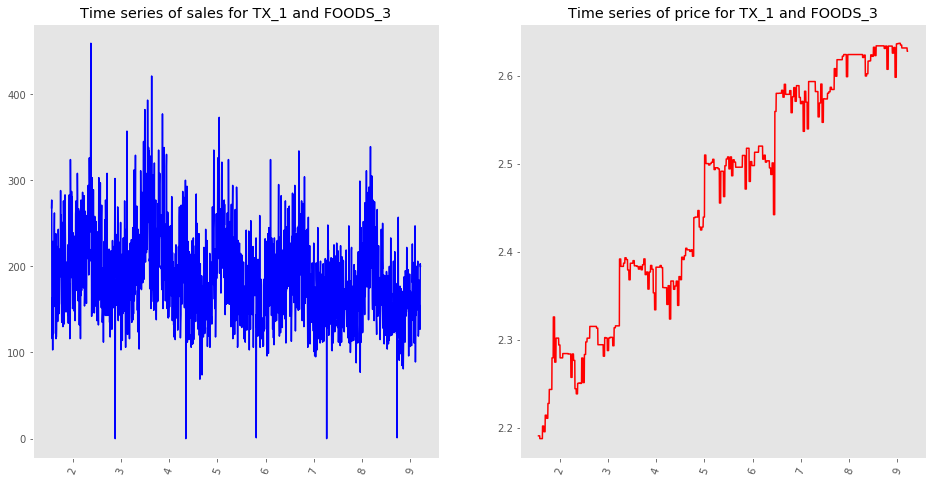

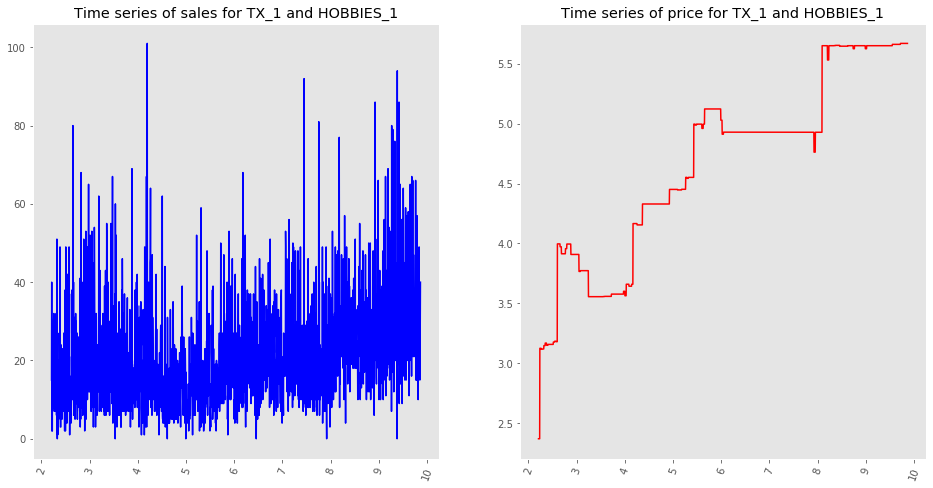

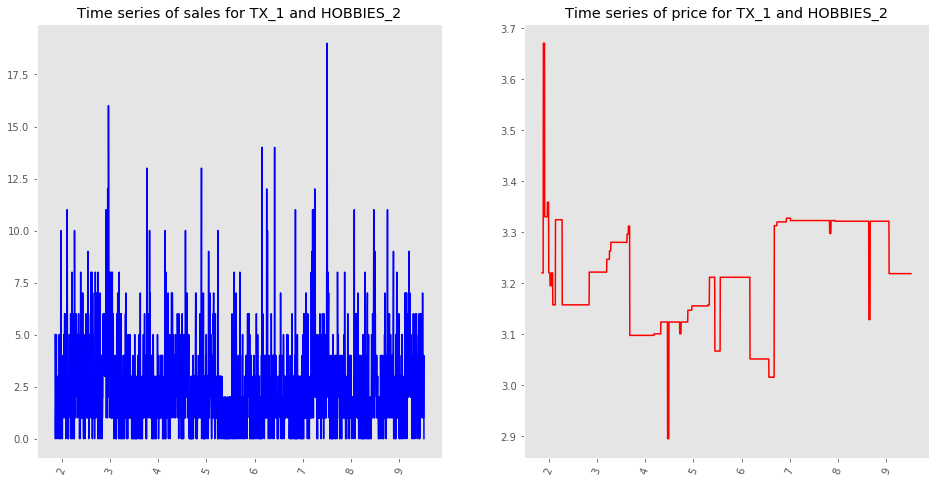

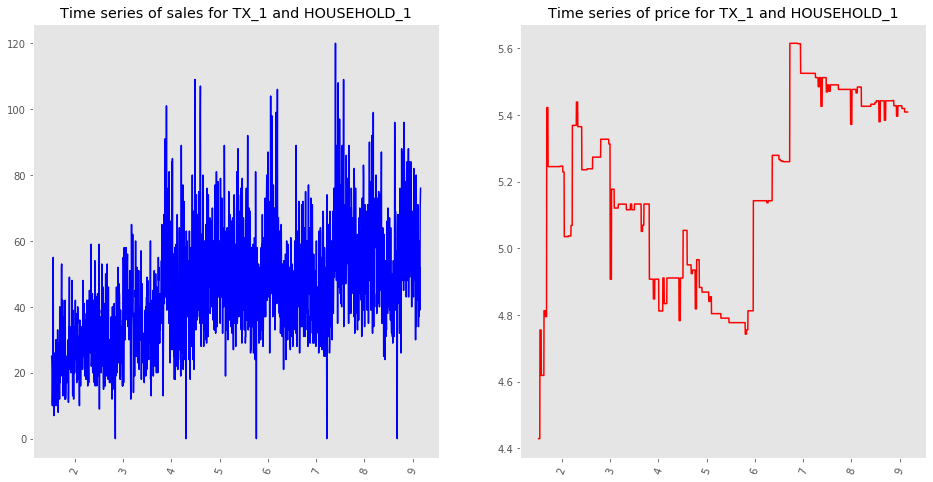

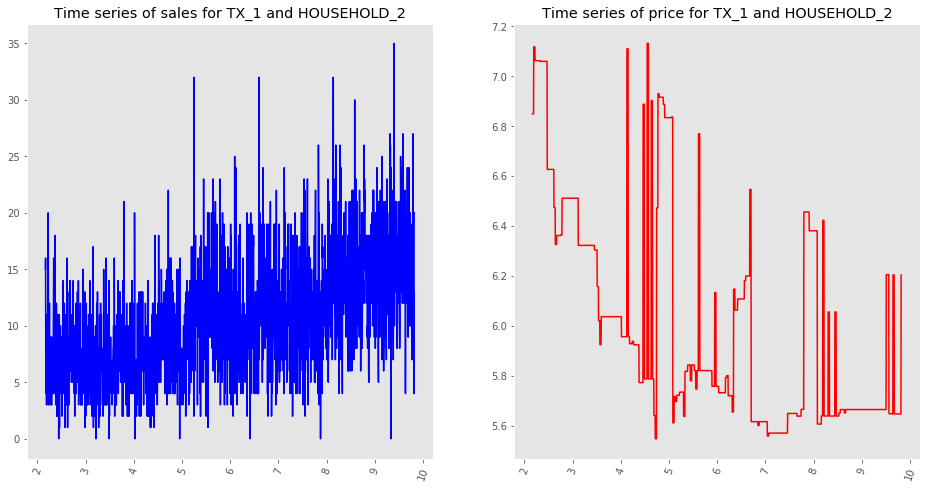

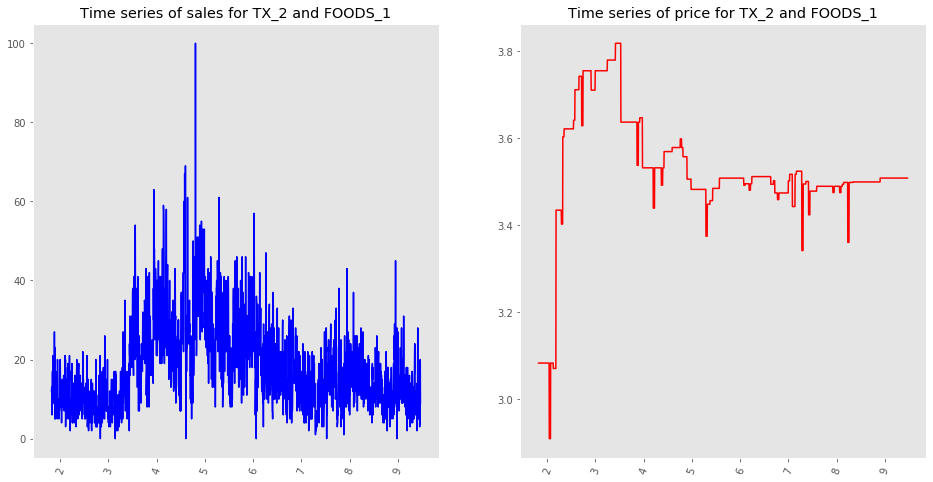

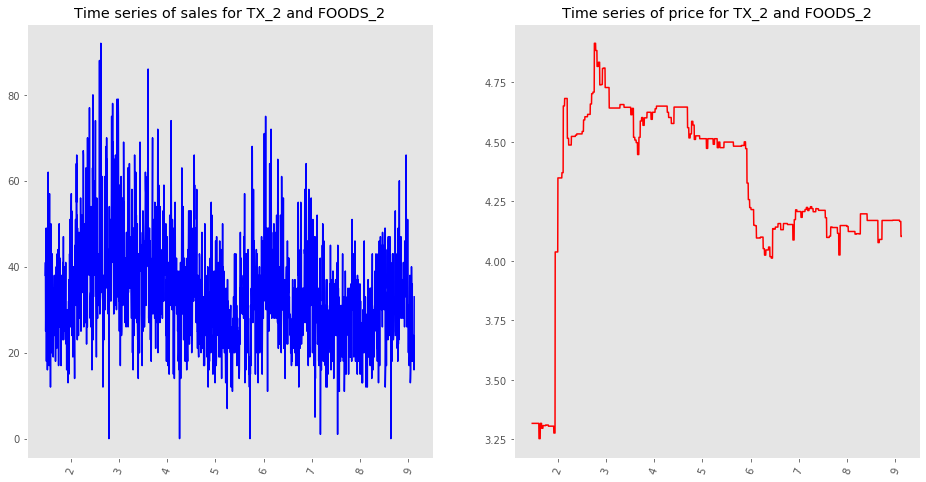

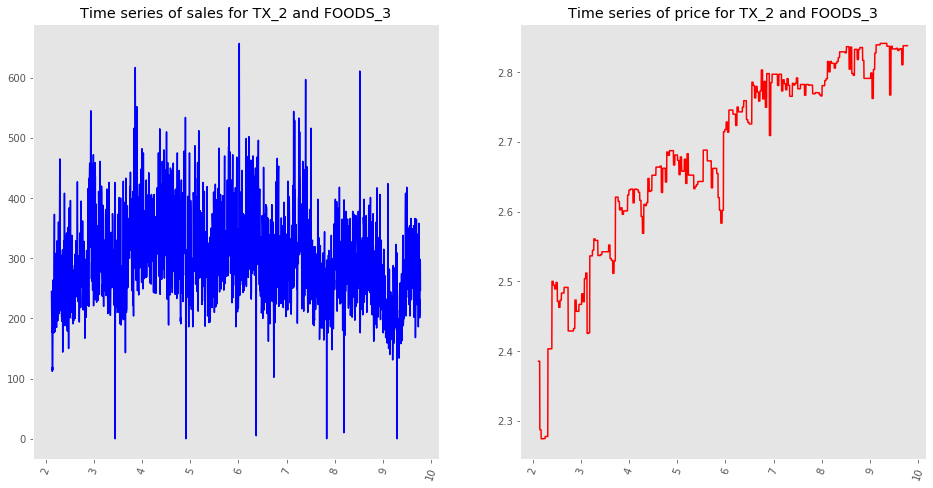

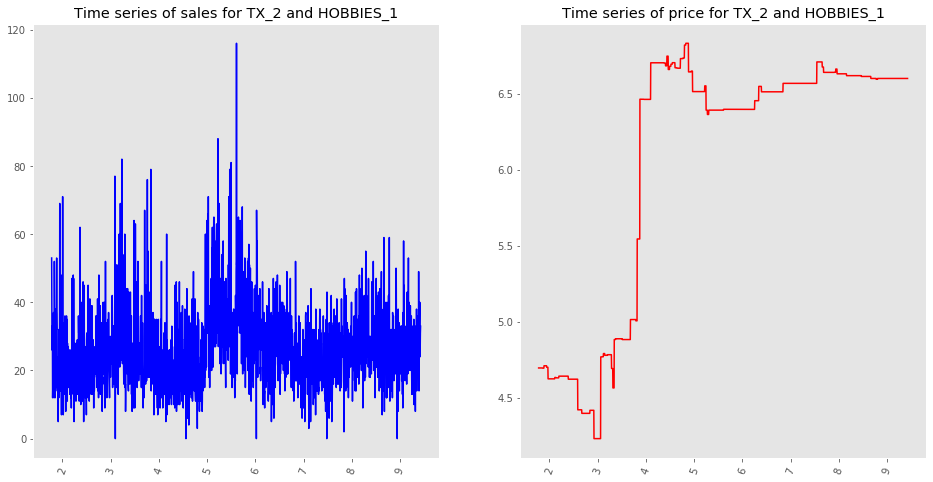

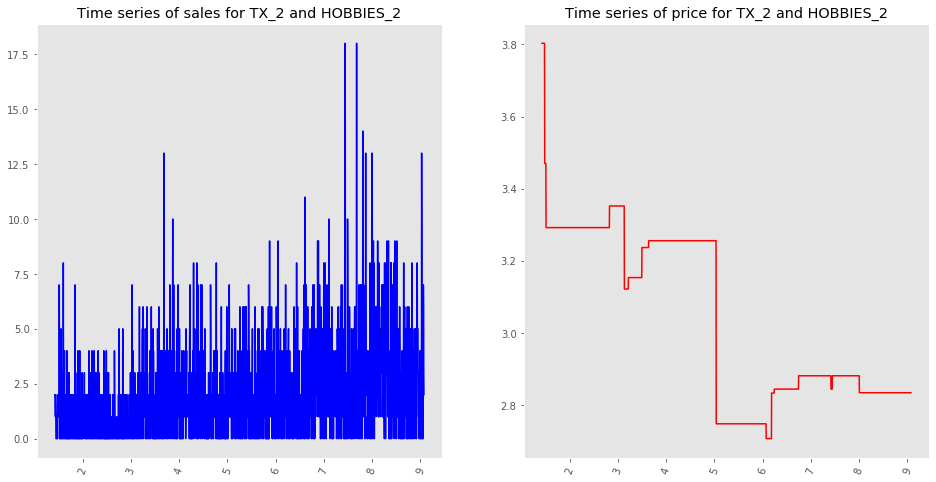

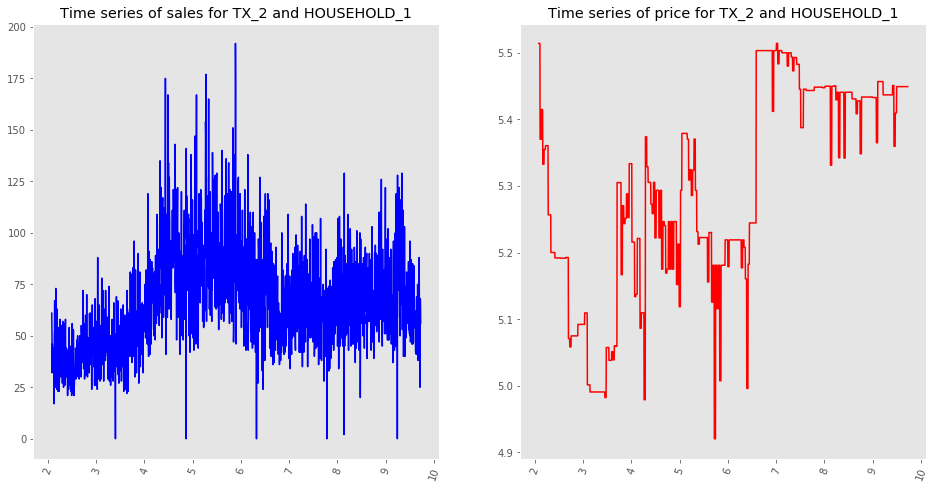

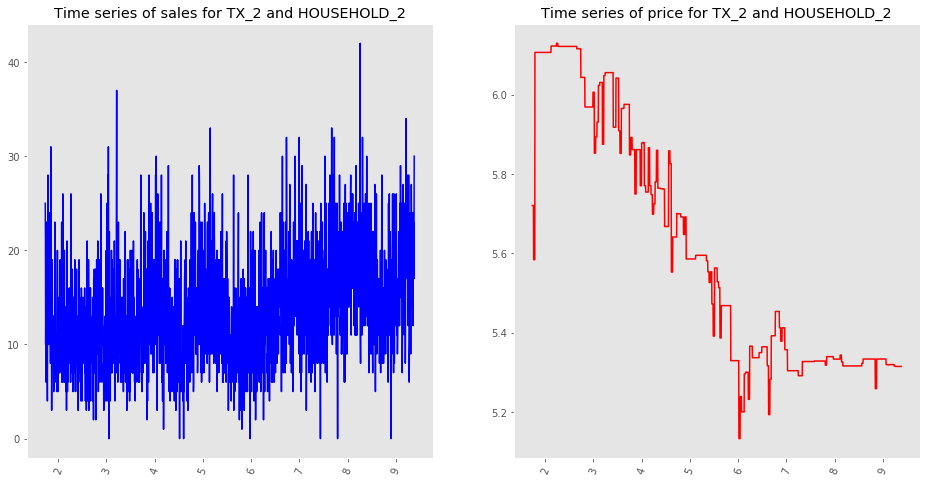

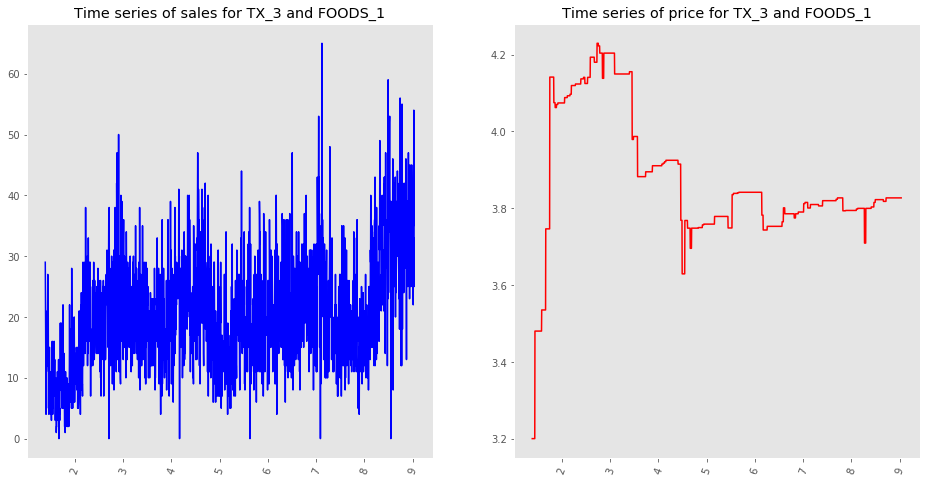

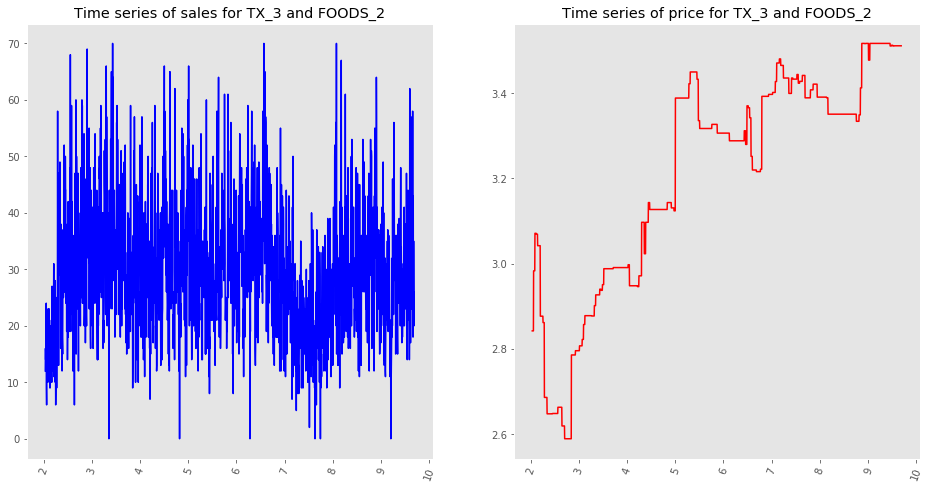

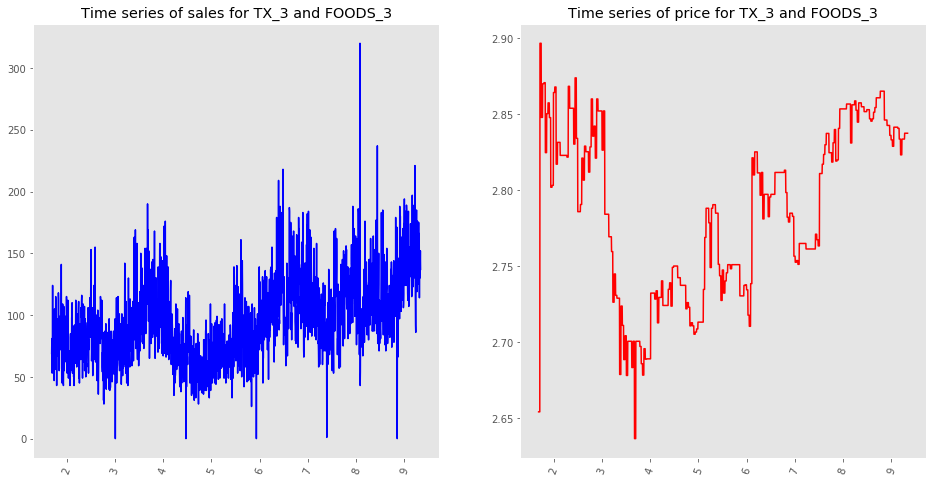

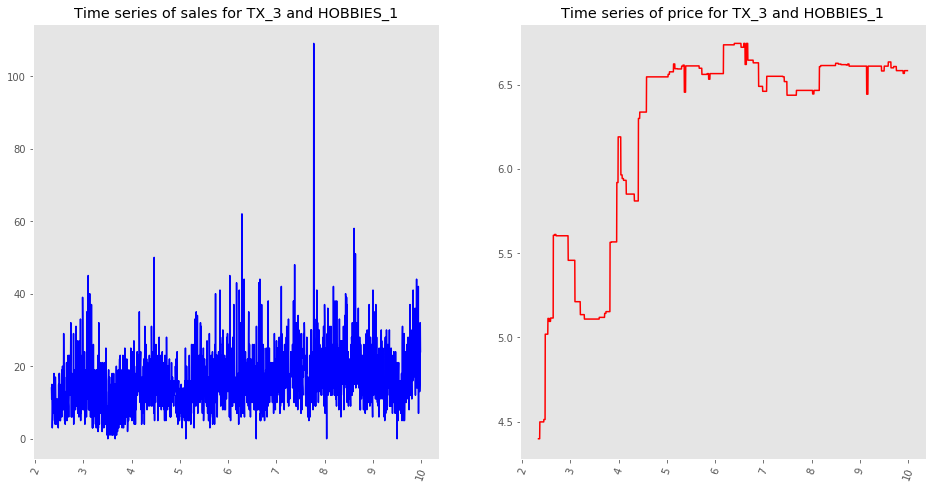

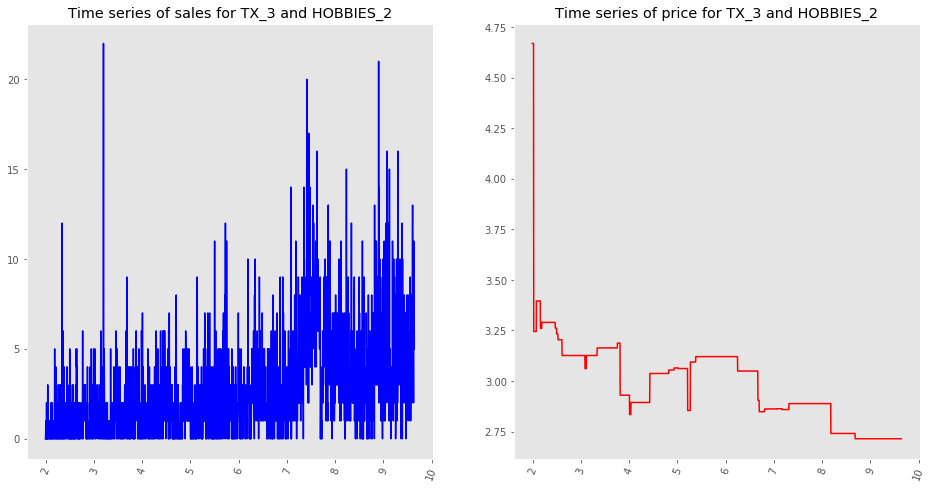

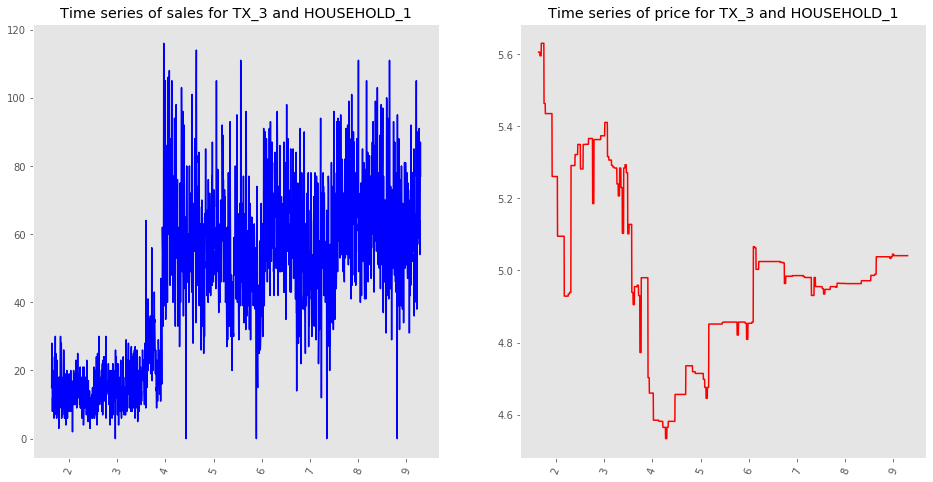

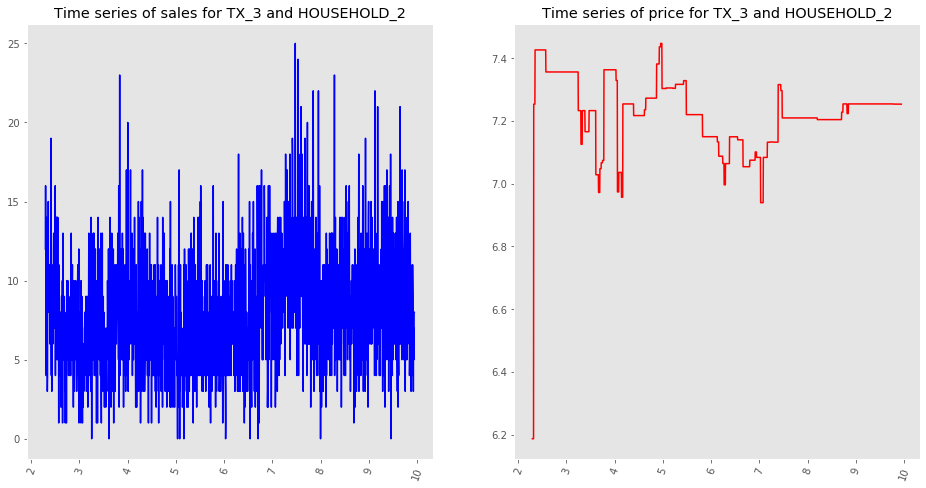

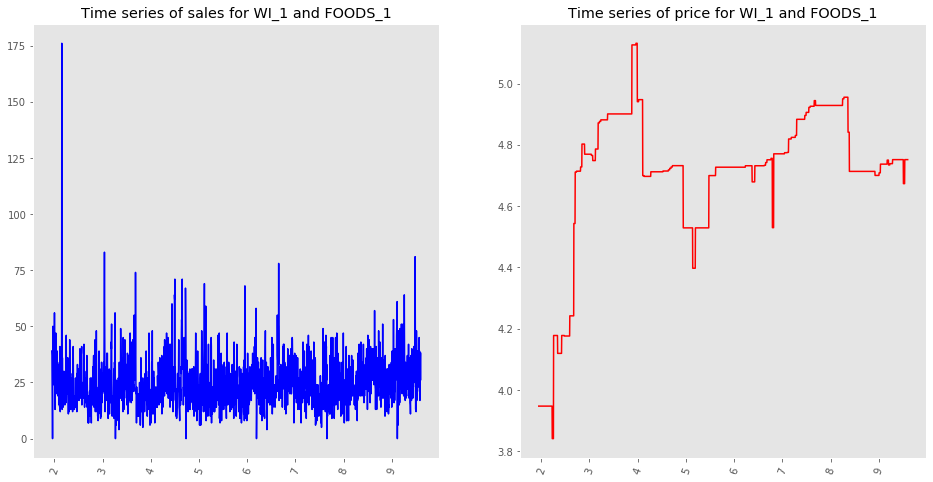

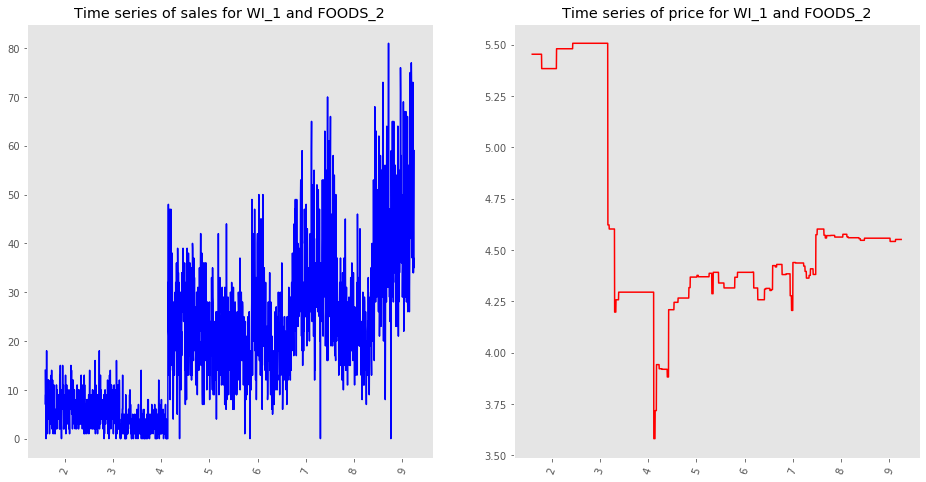

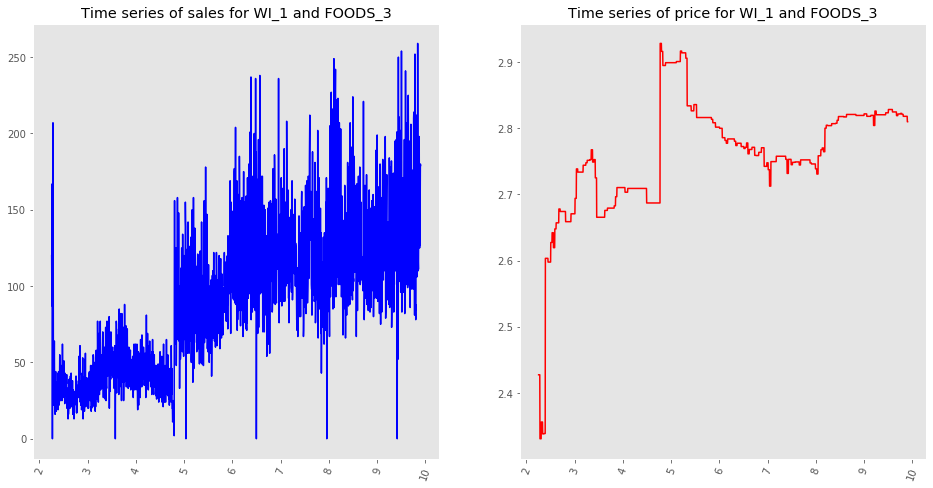

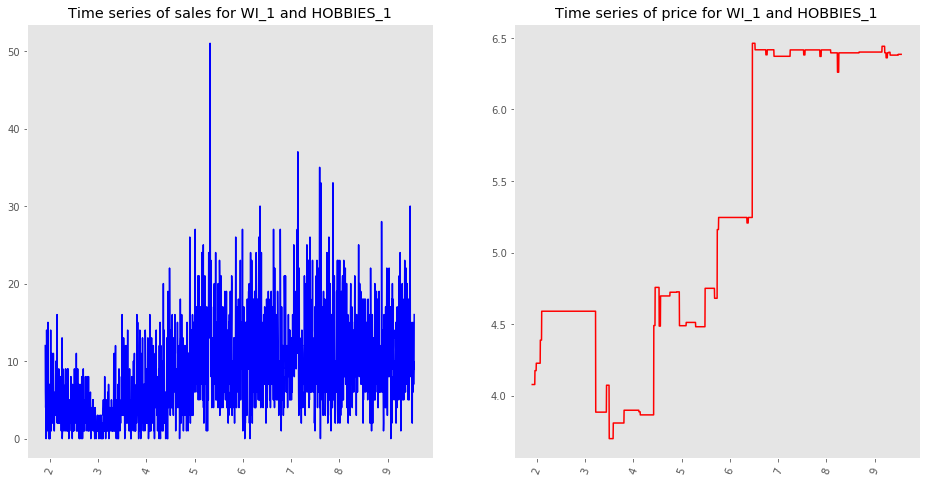

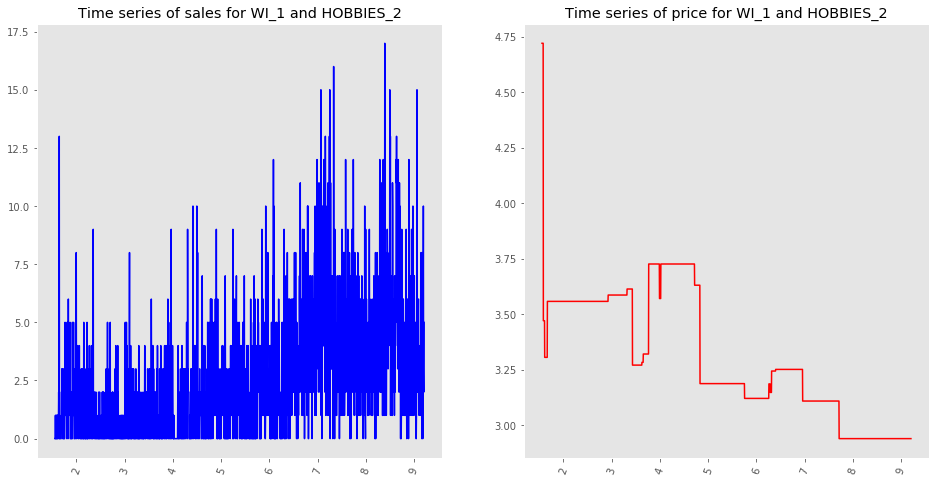

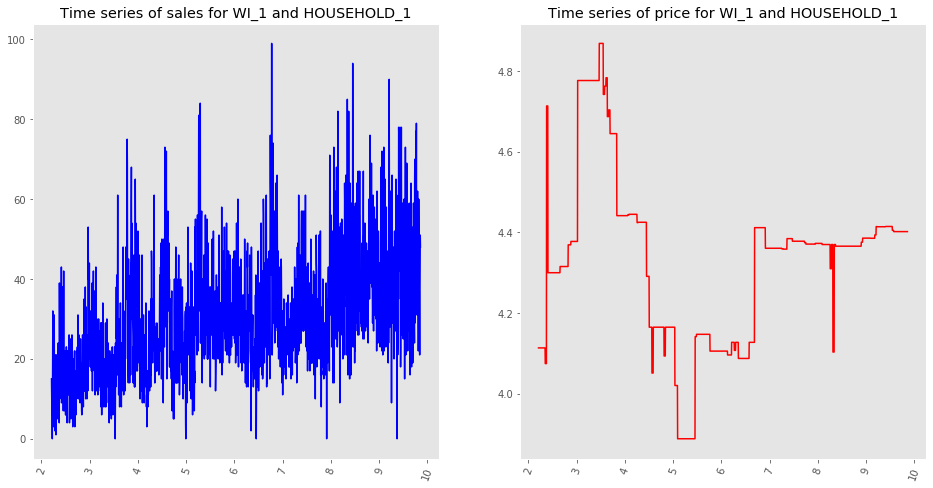

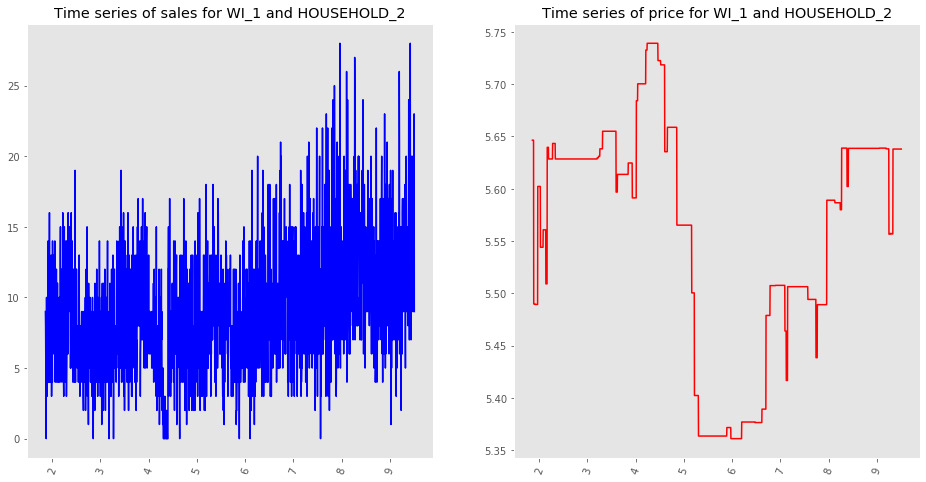

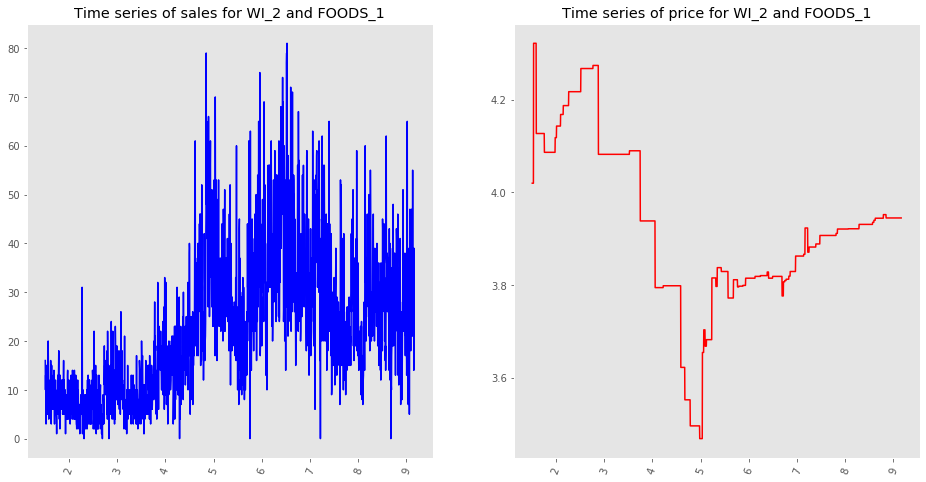

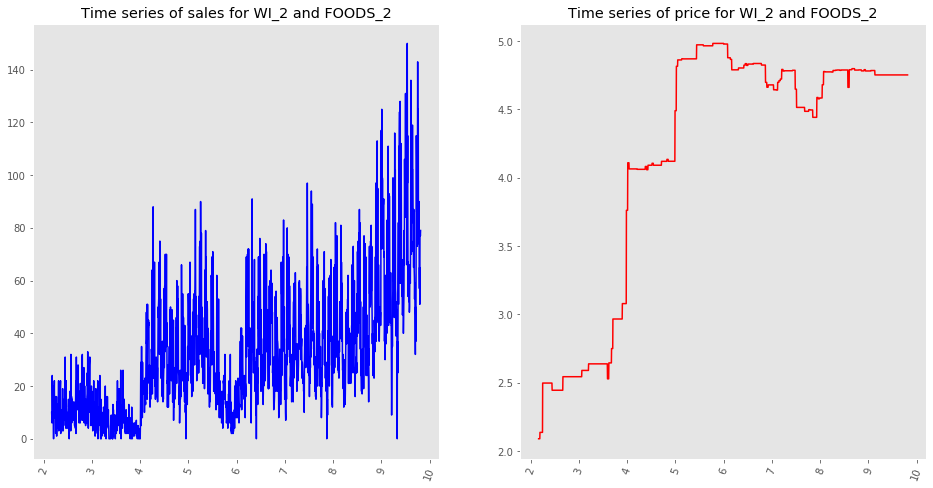

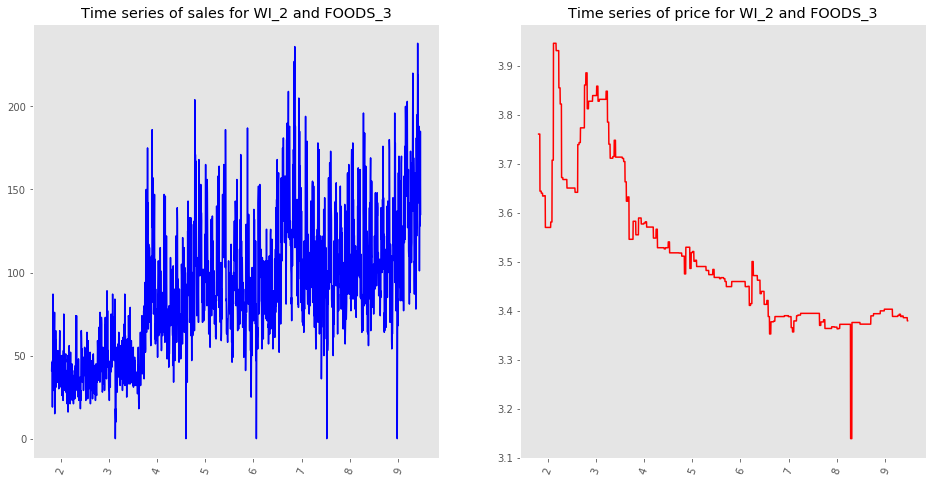

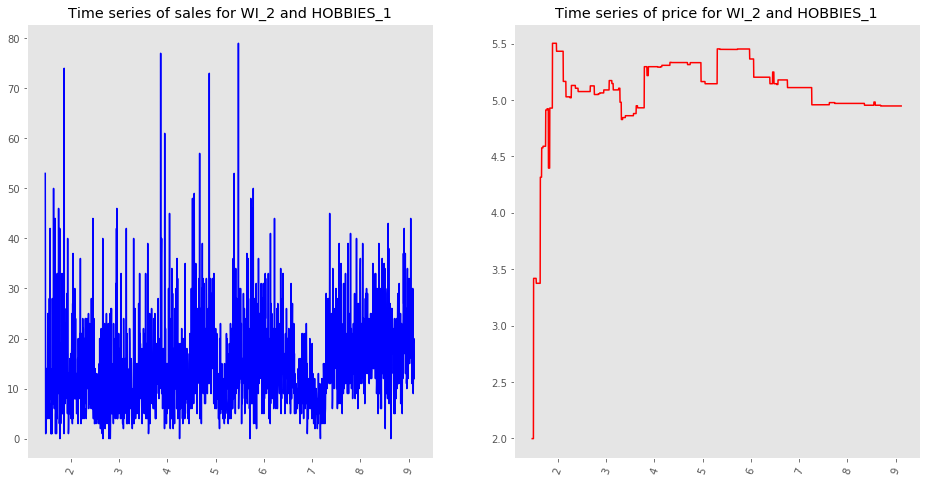

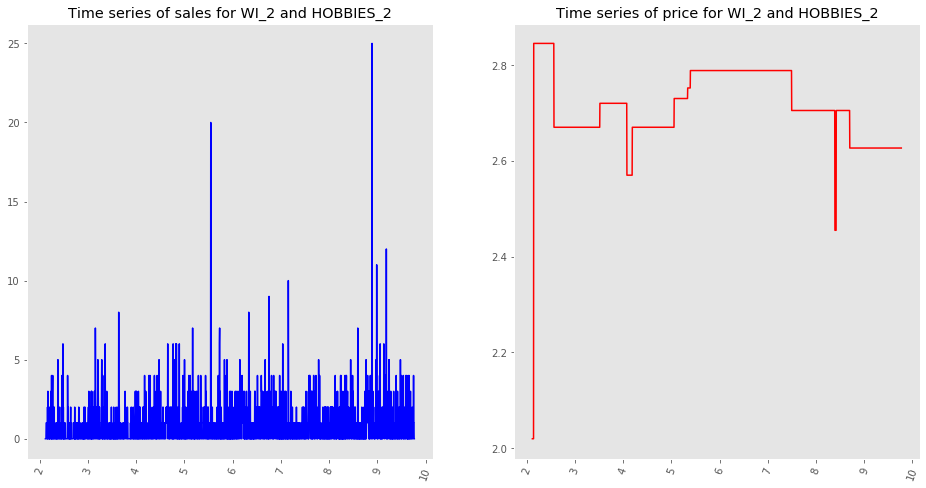

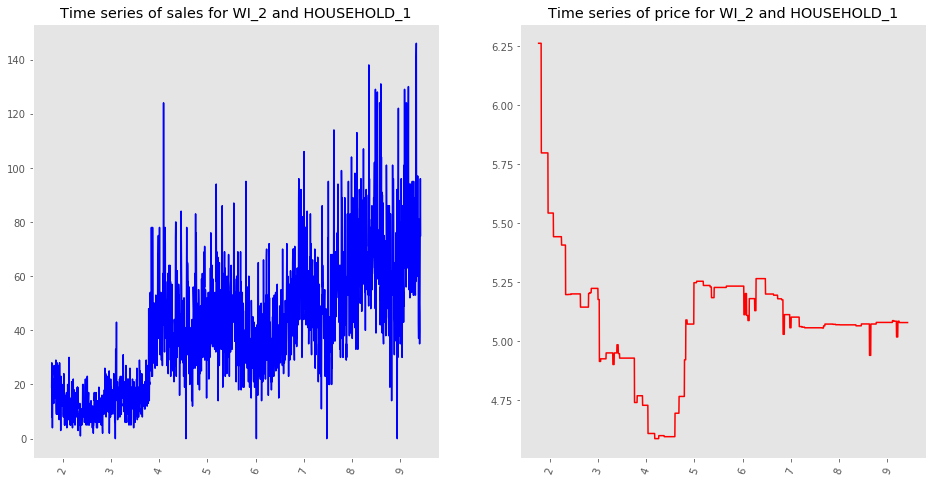

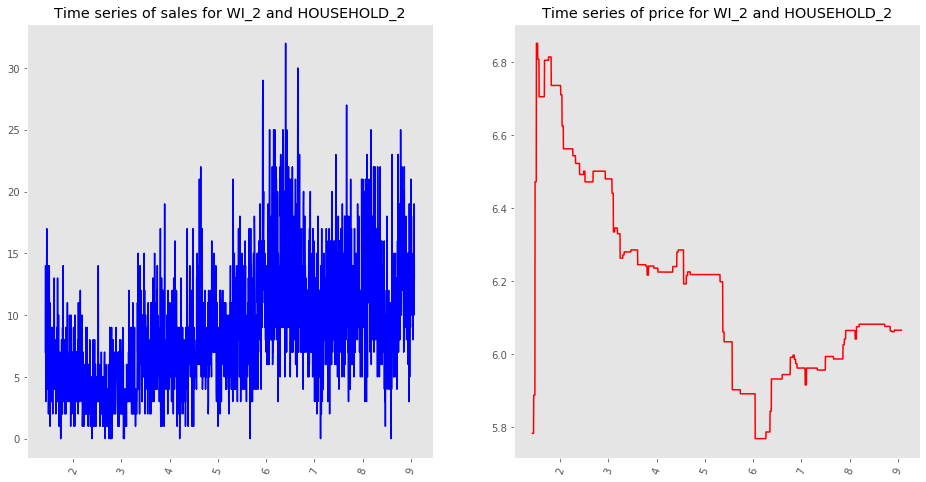

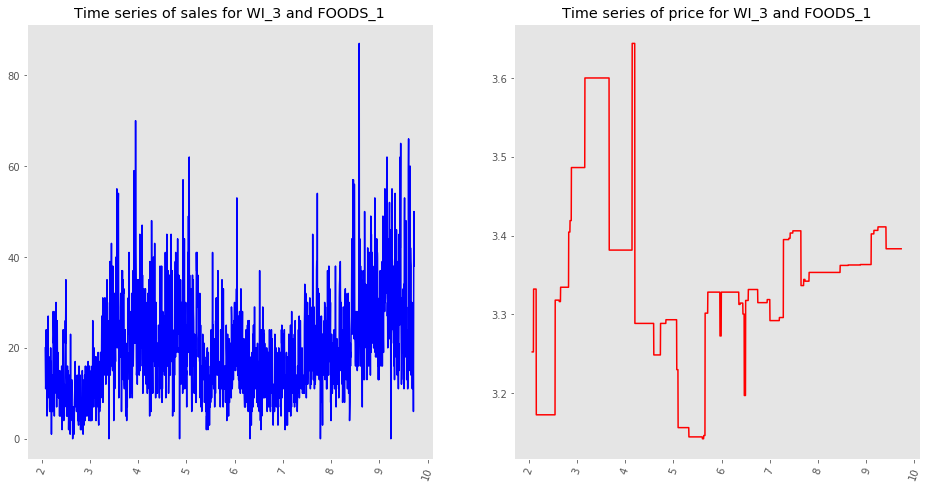

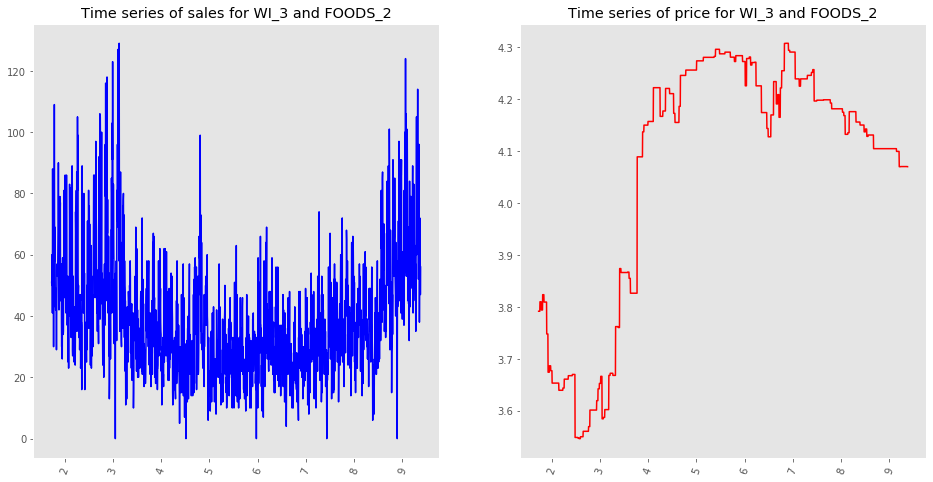

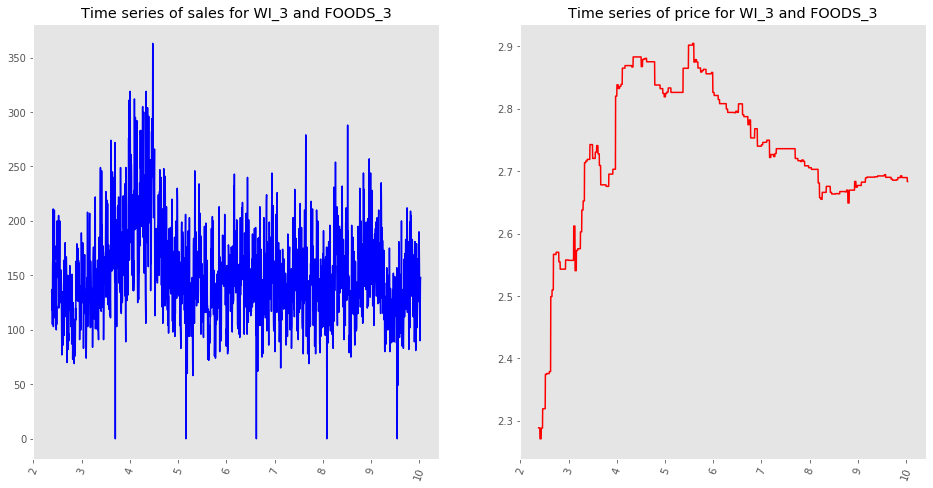

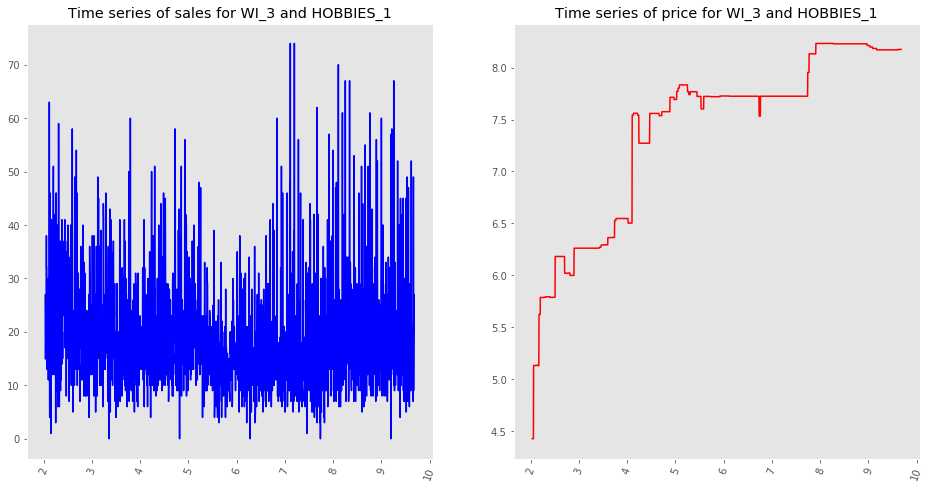

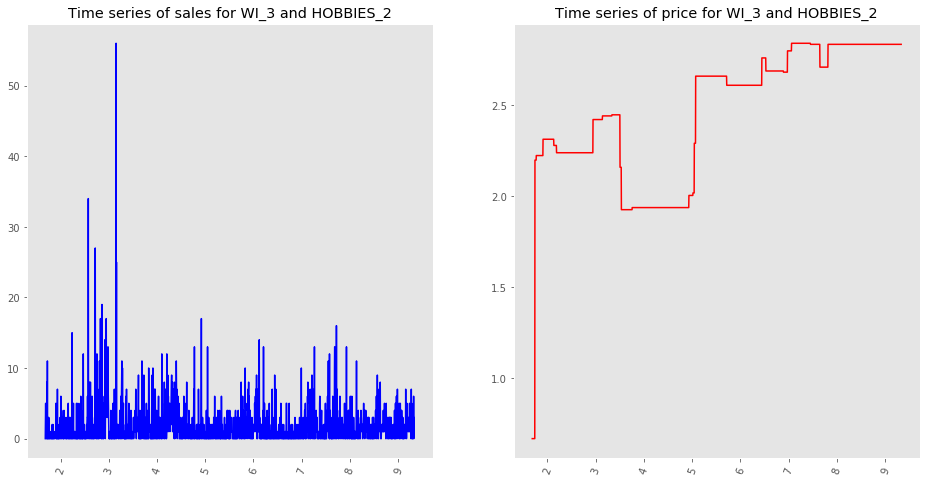

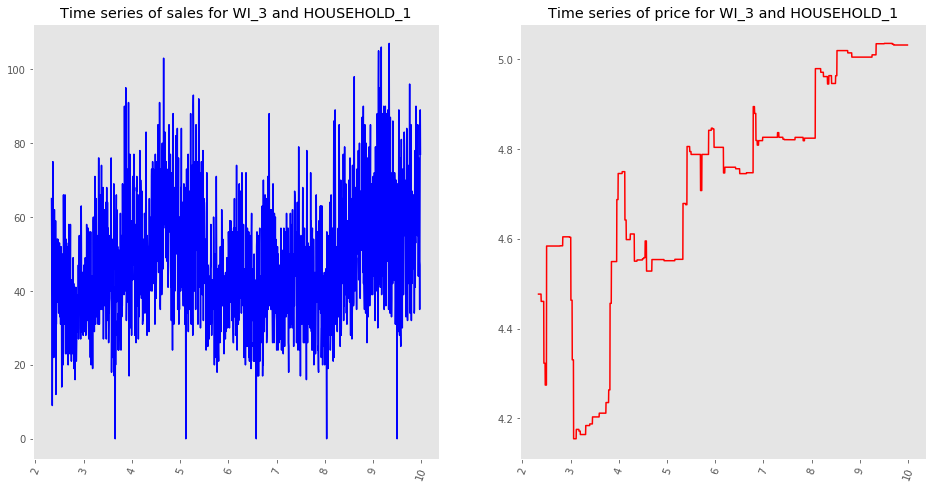

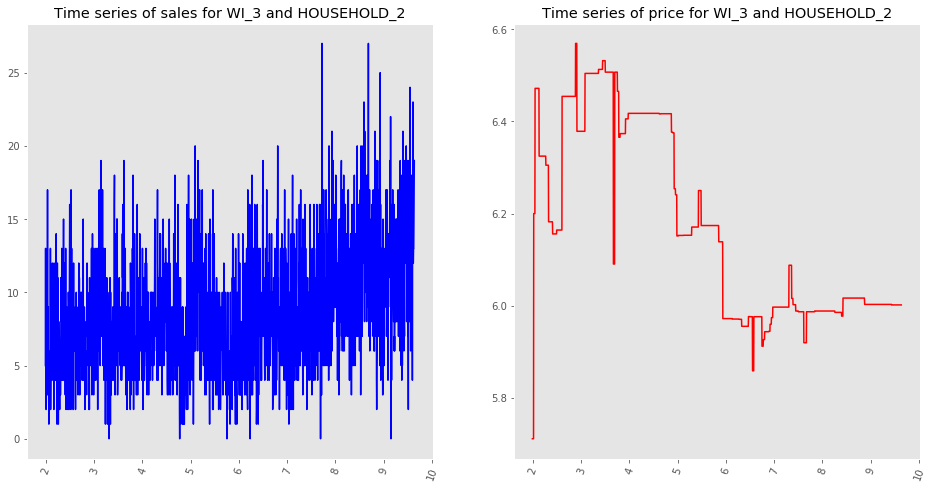

In [10]:
# Level: departments by store
timeseries_particular(dt_work, 'store_id', 'dept_id')